<a href="https://colab.research.google.com/github/LuisArteaga/analysis_infuence_of_news_sentiment_on_german_stock_prices/blob/main/Analysis_of_the_influences_of_news_articles_on_the_development_of_German_share_prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initialisierung

In [ ]:
import os # Zugriff auf Operationen des Betriebssystems.
import feather # Speichern der DataFrames als feather Dateiformat.
import pandas as pd # Erstellung und Verarbeitung von DataFrames.
import re # Nutzung von regulären Ausdrücken
import plotly.express as px # Zur Erstellung von interaktiven Diagrammen
import plotly.io as pio # Bereitstellung von Vorlagen für Diagramme
import plotly.graph_objects as go # Zur Erstellung von kombinierten Diagrammen
from plotly.subplots import make_subplots # Zur Erstellung von Diagrammen mit 2 Y-Achsen
import datetime # Operationen mit Zeitformaten
import numpy as np # Leistungsstarke Funktionen für Vektor und Matrix Operationen
from wordcloud import WordCloud, STOPWORDS # Erstellung von Wort Wolken 
import matplotlib.pyplot as plt # Erstellung von Diagrammen
import seaborn as sns # Erstellung von Diagrammen
from sklearn.model_selection import train_test_split # Einteilung einer Stichprobe in Test- und Trainingsset
from pathlib import Path
from functools import reduce
from statsmodels.tsa.seasonal import seasonal_decompose

In [ ]:
# Modul für den Zugang zu Yahoo Finance Daten
!pip install yfinance

In [ ]:
# Installation von FARM (modifizierte deutsche BERT Version)
!git clone https://github.com/deepset-ai/FARM.git
!cd FARM
!pip install -r requirements.txt
!pip install --editable .

# Order der Arbeitsumgebung definieren
os.chdir('/content/FARM')

# Installation eines Moduls für BERT FARM
!pip install -e .[onnx]

Cloning into 'FARM'...
remote: Enumerating objects: 189, done.
remote: Counting objects: 100% (189/189), done.
remote: Compressing objects: 100% (131/131), done.
remote: Total 5934 (delta 126), reused 102 (delta 58), pack-reused 5745
Receiving objects: 100% (5934/5934), 65.60 MiB | 19.66 MiB/s, done.
Resolving deltas: 100% (4400/4400), done.
Looking in links: https://download.pytorch.org/whl/torch_stable.html
Obtaining file:///content/FARM
  Found existing installation: farm 0.4.6
    Can't uninstall 'farm'. No files were found to uninstall.
  Running setup.py develop for farm
Obtaining file:///content/FARM
  Found existing installation: farm 0.4.6
    Can't uninstall 'farm'. No files were found to uninstall.
  Running setup.py develop for farm


In [ ]:
import torch # ermöglicht die Nutzung einer GPU für Matrix und Vektor Operationen
import tensorflow_probability as tfp
import tensorflow as tf # ermöglicht die Erstellung und das Training von Machine Learning Modellen
import logging # erfasst die Iterationen beim Training des Modells
import yfinance as yf # Schnittstelle zu den Yahoo Finance Daten zu Aktienkursen
from farm.modeling.tokenization import Tokenizer 
from farm.data_handler.processor import TextClassificationProcessor
from farm.data_handler.data_silo import DataSilo
from farm.modeling.language_model import LanguageModel
from farm.modeling.prediction_head import TextClassificationHead, MultiLabelTextClassificationHead
from farm.modeling.adaptive_model import AdaptiveModel
from farm.modeling.optimization import initialize_optimizer
from farm.utils import set_all_seeds, MLFlowLogger, initialize_device_settings
from farm.infer import Inferencer
from farm.train import Trainer
from farm.utils import MLFlowLogger

In [ ]:
try:
    torch.cuda.is_available()

    # Die GPU soll von Pytorch genutzt werden
    device = torch.device("cuda")

    print('Es sind %d GPU(s) verfügbar.' % torch.cuda.device_count())

    print('Es wird die folgende GPU genutzt:', torch.cuda.get_device_name(0))
except RuntimeError:
    print('Keine GPU vorhanden. Daher wird die CPU genutzt.')
    device = torch.device("cpu")

Es sind 1 GPU(s) verfügbar.
Es wird die folgende GPU genutzt: Tesla K80


In [ ]:
"""
Optional: 
"""
from google.colab import drive # Verknüpfung von zum privaten Google Drive Account

# Abfrage für die Zugangsberechtigung zum Google Drive Storage
drive.mount('./drive')

Drive already mounted at ./drive; to attempt to forcibly remount, call drive.mount("./drive", force_remount=True).


# Extrahierung der deutschen Aktienkurse über Yahoo Finance

In [ ]:
def download_dax_stock_data(start, end):
    dax_stocks = dict(dax="^GDAXI", adidas="ADS.DE", allianz="ALV.DE", basf="BAS.DE", bayer="BAYN.DE",
                      beiersdorf="BEI.DE", bmw="BMW.DE", continental="CON.DE", covestro="1COV.DE", daimler="DAI.DE",
                      deutsche_bank="DBK.DE", deutsche_boerse="DB1.DE", deutsche_lufthansa="LHA.DE",
                      deutsche_post="DPW.DE", deutsche_telekom="DTE.DE", eon="EOAN.DE", fresenius="FRE.DE",
                      fresenius_medical_care="FME.DE", heidelberg_cement="HEI.DE", henkel="HEN3.DE", infineon="IFX.DE",
                      linde="LIN.DE", merck="MRK.DE", mtu_aero_engines="MTX.DE", muenchener_rueckversicherung="MUV2.DE",
                      rwe="RWE.DE", sap="SAP.DE", siemens="SIE.DE", volkswagen="VOW3.DE", vonovia="VNA.DE",
                      wirecard="WDI.DE")
    index = list()
    for stock_name in dax_stocks:
      data = pd.DataFrame(yf.Ticker(dax_stocks[stock_name])
                          .history(start=start, end=end)) \
                          .reset_index()[['Date', 'Close']] \
                          .rename(columns={"Close": dax_stocks[stock_name]})
      index.append(data)
    
    dax_matrix = reduce(lambda left, right: pd.merge(left, right, on='Date', left_index=True), index)

    return dax_matrix

In [ ]:
dax_stocks_df = download_dax_stock_data(start = '2018-01-01', end = '2020-04-01')

07/12/2020 10:38:41 - INFO - numexpr.utils -   NumExpr defaulting to 2 threads.


In [ ]:
dax_stocks_df.head(5)

Date    ^GDAXI  ADS.DE  ALV.DE  ...  SIE.DE  VOW3.DE  VNA.DE    WDI.DE
0 2018-01-02  12871.39  157.27  166.45  ...  103.81   156.69   36.07   93.0456
1 2018-01-03  12978.21  158.12  166.71  ...  104.92   162.12   36.91   95.4794
2 2018-01-04  13167.89  160.19  168.87  ...  107.79   164.95   36.84   96.8959
3 2018-01-05  13319.64  161.88  171.51  ...  108.20   169.46   37.02   99.2300
4 2018-01-08  13367.78  162.54  171.77  ...  109.00   170.06   37.42  105.6837

[5 rows x 32 columns]

# Datenvisualisierung der DAX Aktienkurse

In [ ]:
def show_correlation_matrix(df):
    corr_df = df.corr(method='spearman')
    mask = np.zeros_like(corr_df)
    mask[np.triu_indices_from(mask)] = True
    sns.set(font_scale=1.1)
    sns.heatmap(corr_df,
                cmap='RdYlGn',
                vmax=1.0,
                vmin=-1.0,
                mask=mask,
                linewidths=2.5,
                yticklabels=True,
                xticklabels=True,
                annot=True)
    fig = plt.gcf()
    figsize = fig.get_size_inches()
    fig.set_size_inches(figsize * 5)
    plt.yticks(rotation=0)
    plt.xticks(rotation=90)
    plt.show()

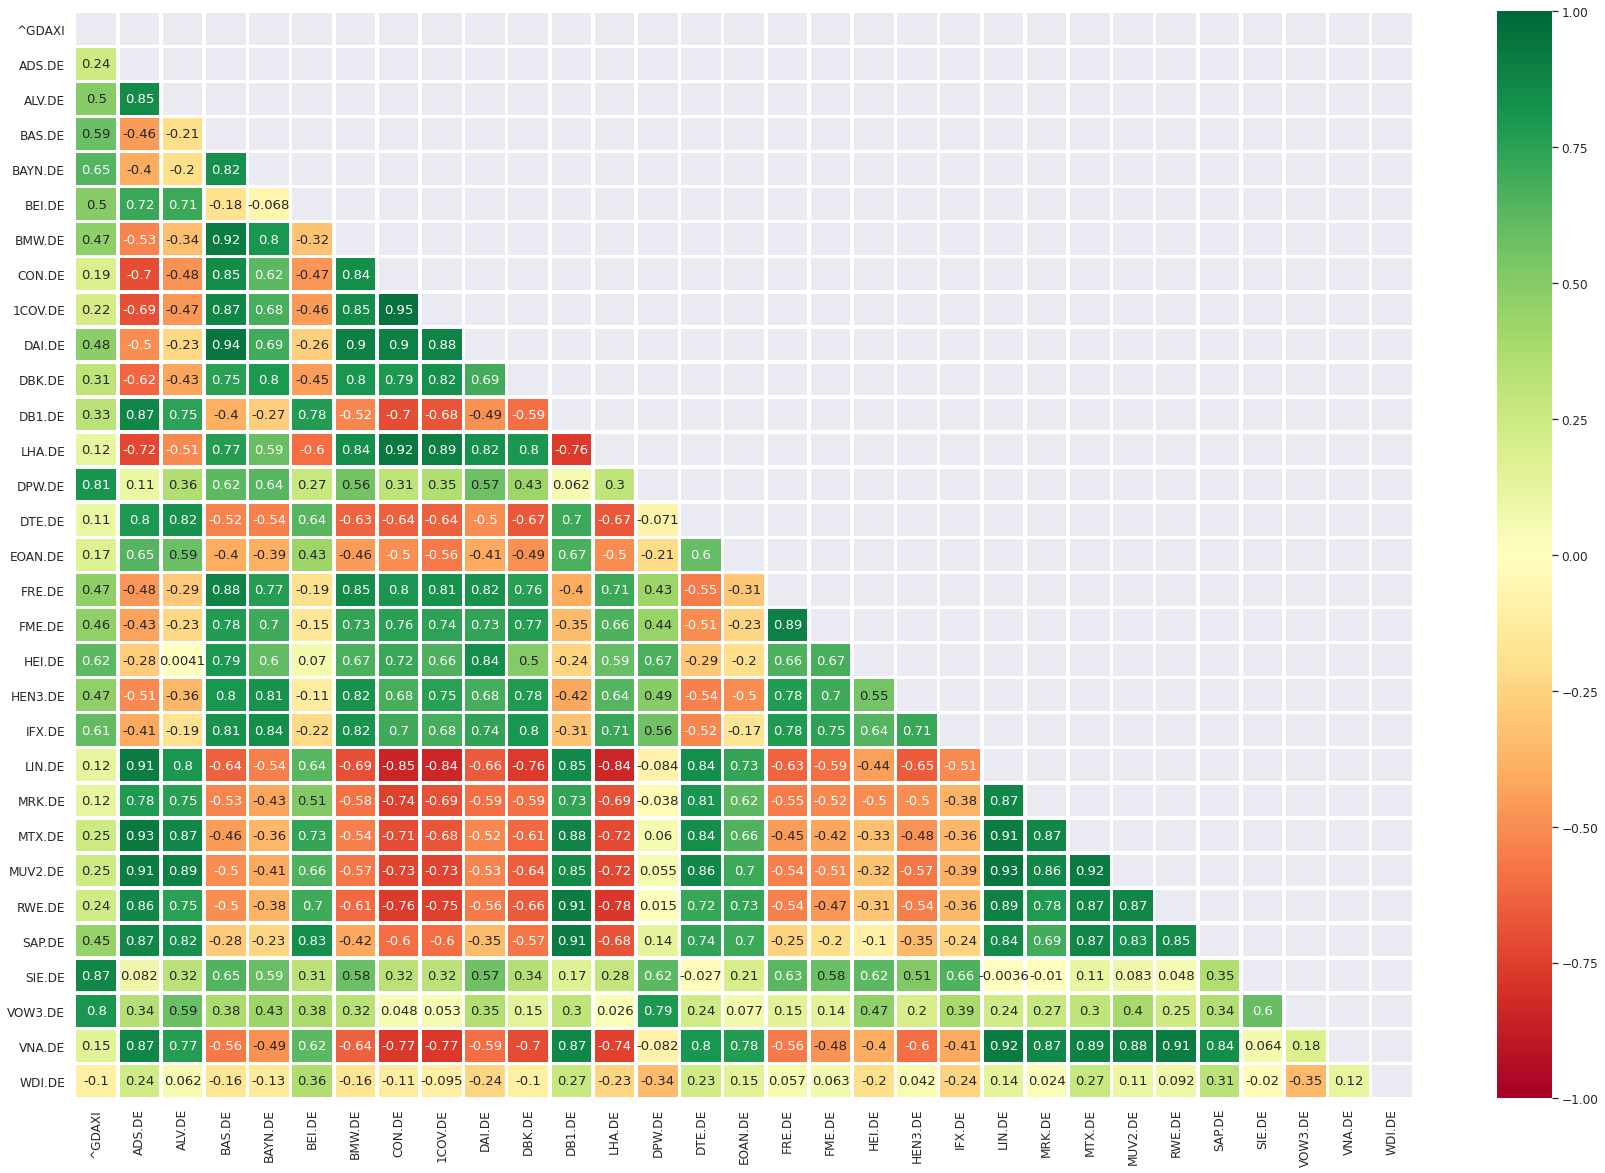

In [ ]:
show_correlation_matrix(dax_stocks_df)

In [ ]:
# Niedrigste Aktienkurse
dax_stocks_df[['ADS.DE','ALV.DE', 'BEI.DE', 'DBK.DE', 'LHA.DE', 'DTE.DE', 'SIE.DE', 'VNA.DE', 'WDI.DE']].min()

ADS.DE    156.57
ALV.DE    111.92
BEI.DE     80.35
DBK.DE      4.87
LHA.DE      8.26
DTE.DE      9.49
SIE.DE     60.88
VNA.DE     31.94
WDI.DE     83.24
dtype: float64

In [ ]:
# Höchste Aktienkurse
dax_stocks_df[['ADS.DE','ALV.DE', 'BEI.DE', 'DBK.DE', 'LHA.DE', 'DTE.DE', 'SIE.DE', 'VNA.DE', 'WDI.DE']].max()

ADS.DE    309.8200
ALV.DE    218.2000
BEI.DE    115.4900
DBK.DE     15.8800
LHA.DE     29.0300
DTE.DE     14.5600
SIE.DE    115.7900
VNA.DE     50.8000
WDI.DE    195.4974
dtype: float64

## Auswahl der zu untersuchenden Aktienkurse

# Datenvisualisierung der zu untersuchenden Aktien

In [ ]:
def download_dax_stock_data(start, end):
    dax_stocks = dict(adidas="ADS.DE", allianz="ALV.DE", 
                      beiersdorf="BEI.DE", deutsche_bank="DBK.DE", deutsche_lufthansa="LHA.DE",
                      deutsche_telekom="DTE.DE", siemens="SIE.DE", volkswagen="VOW3.DE", vonovia="VNA.DE",
                      wirecard="WDI.DE")
    index = list()
    for stock_name in dax_stocks:
      data = pd.DataFrame(yf.Ticker(dax_stocks[stock_name])
                          .history(start=start, end=end)) \
                          .reset_index()[['Date', 'Close']] \
                          .rename(columns={"Close": dax_stocks[stock_name]})
      index.append(data)
    
    dax_matrix = reduce(lambda left, right: pd.merge(left, right, on='Date', left_index=True), index)

    return dax_matrix

In [ ]:
subset_dax_stocks_df = download_dax_stock_data('2018-01-01', '2020-04-01')

In [ ]:
def show_boxplot(df):
    df.iloc[:, 1:].plot(kind='box')
    fig = plt.gcf()
    figsize = fig.get_size_inches()
    fig.set_size_inches(figsize * 5)
    plt.title('Stock Prices')
    plt.show()

In [ ]:
def normalization(df):
    data = dict()
    data['Date'] = df['Date']
    for stock_id in df.columns[1:]:
        max_stock_price = df.loc[:, stock_id].max()
        min_stock_price = df.loc[:, stock_id].min()
        val = (df.loc[:, stock_id] - min_stock_price) / (max_stock_price - min_stock_price)
        data[stock_id] = val
    new_df = pd.DataFrame(data=data)

    return new_df


def standardization(df):
    data = dict()
    data['Date'] = df['Date']
    for stock_id in df.columns[1:]:
        mean_stock_price = df.loc[:, stock_id].mean()
        std_stock_price = df.loc[:, stock_id].std()
        val = (df.loc[:, stock_id] - mean_stock_price) / std_stock_price
        data[stock_id] = val
    new_df = pd.DataFrame(data=data)

    return new_df

In [ ]:
sub_dax_stocks_norm_df = normalization(subset_dax_stocks_df)
sub_dax_stocks_standard_df = standardization(subset_dax_stocks_df)

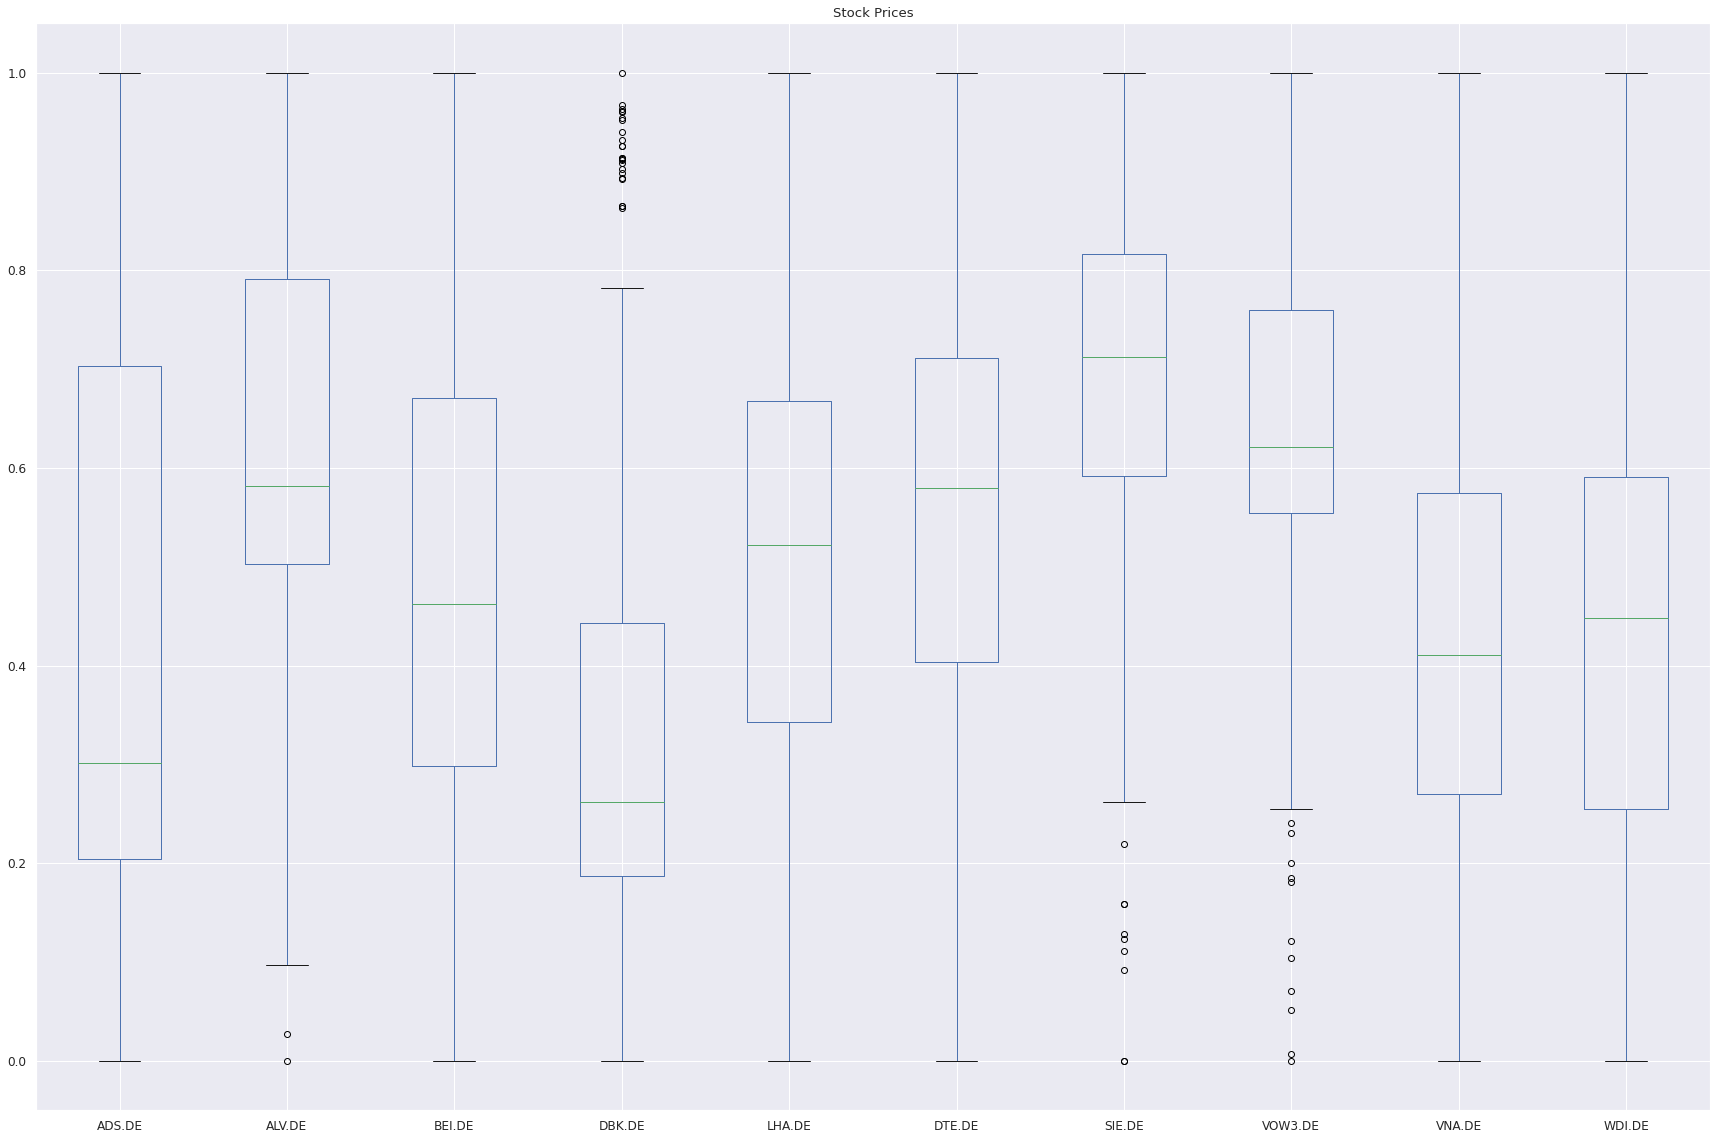

In [ ]:
show_boxplot(sub_dax_stocks_norm_df)

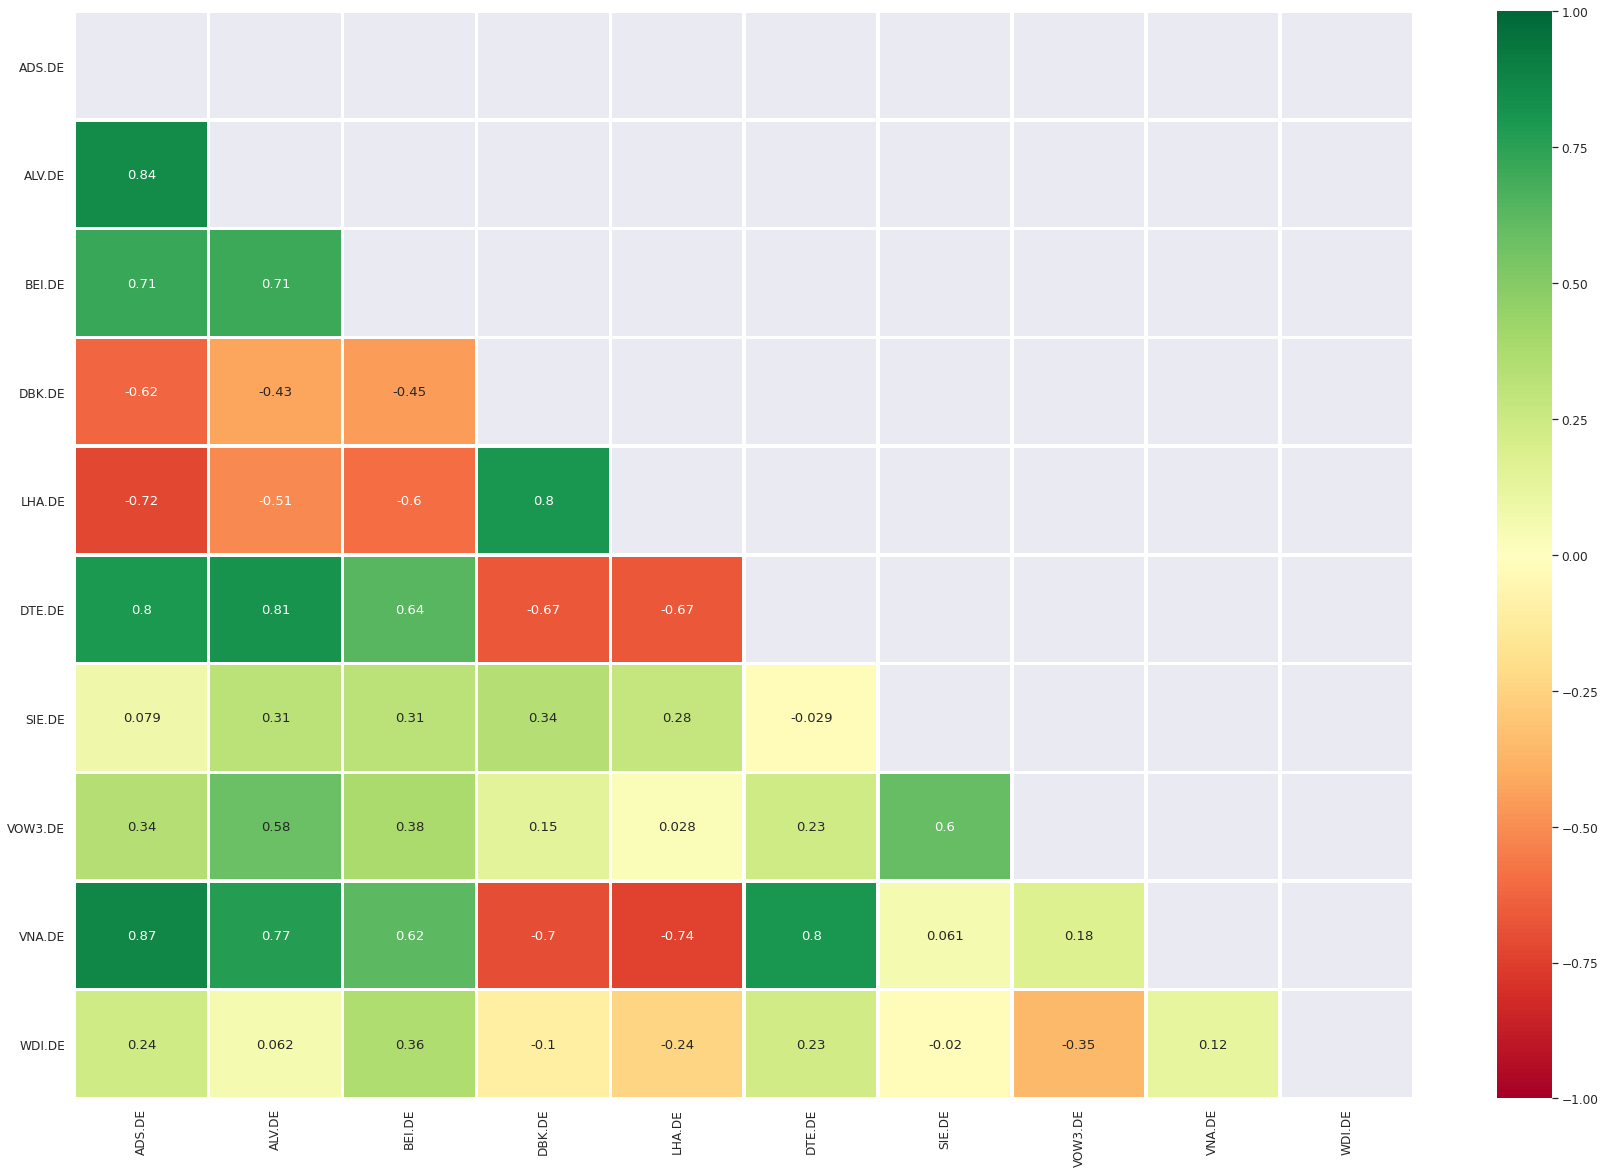

In [ ]:
show_correlation_matrix(subset_dax_stocks_df)

In [ ]:
def show_time_series(df):
    temp_df = df.copy()
    for stock_ids in temp_df.columns[1:]:
        plt.plot(temp_df['Date'], temp_df[stock_ids], label = stock_ids)
    plt.xlabel('Datum')
    plt.ylabel('Aktienpreis in Euro')
    plt.title('Aktienpreise der DAX Unternehmen im Zeitverlauf')
    plt.legend()
    fig = plt.gcf()
    figsize = fig.get_size_inches()
    fig.set_size_inches(figsize * 5)
    plt.show()

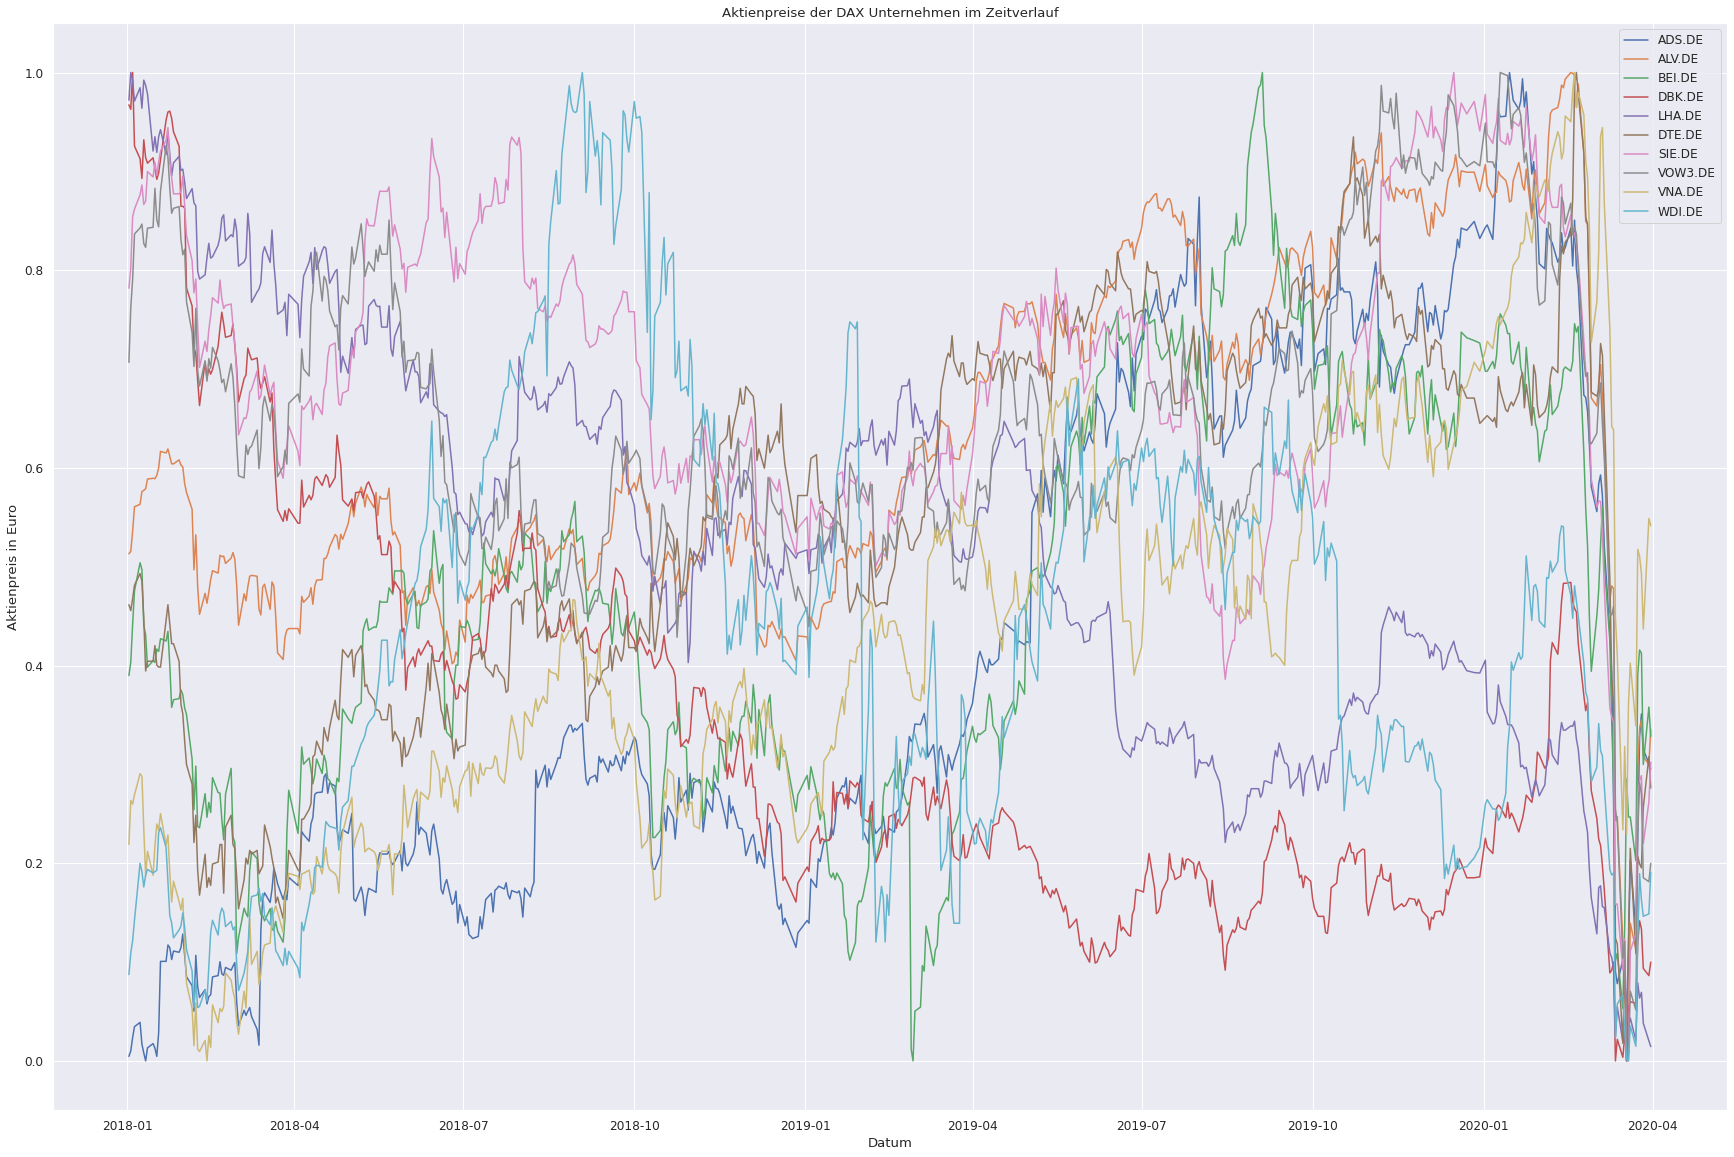

In [ ]:
show_time_series(sub_dax_stocks_norm_df)

# Datenextrahierung der Finanzen.net Nachrichten

In [ ]:
"""
Order wird erstellt. Dort sollen die Dateien mit den Titeln der 
Nachrichtenartikeln zu den ausgewählten deutschen Aktien gespeichert werden.
"""
!mkdir finanzen_net_news_titles

In [ ]:
"""
Die archivierte Datei mit den Titeln der Nachrichtenartikeln zu den 
ausgewählten deutschen Aktien wird heruntergeladen
"""
!wget  -O /content/FARM/finanzen_net_news_titles/finanzen_net_news_titles.tar "https://storage.googleapis.com/finanzen_net_news_titles/finanzen_net.tar"

--2020-07-12 10:38:58--  https://storage.googleapis.com/finanzen_net_news_titles/finanzen_net.tar
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.166.128, 74.125.140.128, 173.194.76.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.166.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 809984 (791K) [application/x-tar]
Saving to: ‘/content/FARM/finanzen_net_news_titles/finanzen_net_news_titles.tar’

/content/FARM/finan 100%[===================>] 791.00K  --.-KB/s    in 0.007s  

2020-07-12 10:38:58 (118 MB/s) - ‘/content/FARM/finanzen_net_news_titles/finanzen_net_news_titles.tar’ saved [809984/809984]



In [ ]:
"""
Die archivierte Datei wird entpackt
"""
!tar -C /content/FARM/finanzen_net_news_titles -xvf /content/FARM/finanzen_net_news_titles/finanzen_net_news_titles.tar

adidas-1.csv
adidas-10.csv
adidas-11.csv
adidas-12.csv
adidas-13.csv
adidas-14.csv
adidas-15.csv
adidas-16.csv
adidas-17.csv
adidas-18.csv
adidas-19.csv
adidas-2.csv
adidas-20.csv
adidas-21.csv
adidas-22.csv
adidas-23.csv
adidas-24.csv
adidas-25.csv
adidas-3.csv
adidas-4.csv
adidas-5.csv
adidas-6.csv
adidas-7.csv
adidas-8.csv
adidas-9.csv
allianz-1.csv
allianz-10.csv
allianz-11.csv
allianz-12.csv
allianz-13.csv
allianz-14.csv
allianz-15.csv
allianz-16.csv
allianz-17.csv
allianz-18.csv
allianz-19.csv
allianz-2.csv
allianz-20.csv
allianz-21.csv
allianz-22.csv
allianz-23.csv
allianz-24.csv
allianz-25.csv
allianz-3.csv
allianz-4.csv
allianz-5.csv
allianz-6.csv
allianz-7.csv
allianz-8.csv
allianz-9.csv
beiersdorf-1.csv
beiersdorf-10.csv
beiersdorf-11.csv
beiersdorf-12.csv
beiersdorf-13.csv
beiersdorf-14.csv
beiersdorf-15.csv
beiersdorf-16.csv
beiersdorf-17.csv
beiersdorf-18.csv
beiersdorf-19.csv
beiersdorf-2.csv
beiersdorf-20.csv
beiersdorf-21.csv
beiersdorf-22.csv
beiersdorf-23.csv
beiersd

In [ ]:
# Die archivierte Datei wird gelöscht.
!rm /content/FARM/finanzen_net_news_titles/finanzen_net_news_titles.tar

In [ ]:
# Ein leerer DataFrame wird erstellt.
finanzen_net_df = pd.DataFrame(columns=['date','title','stock']) 

In [ ]:
"""
Filtereinstellung mit den ausgewählten deutschen Aktien 
für die nachfolgende Datentransformation
"""
stock_names = ['adidas', 
               'allianz', 
               'beiersdorf', 
               'deutsche_bank',
               'deutsche_telekom',
               'lufthansa',
               'siemens',
               'volkswagen',
               'vonovia',
               'wirecard']

In [ ]:
# Mehrere CSV Dateien werden geladen und in einem DataFrame gespeichert.
for stock in stock_names:
  for file_name in os.listdir('/content/FARM/finanzen_net_news_titles/'):
    if re.match(stock, file_name):
      file_path = os.path.join('/content/FARM/finanzen_net_news_titles/',
                                          file_name)
      if os.path.getsize(file_path) > 0:
        temp_df = pd.read_csv(file_path,
                              encoding = "ISO-8859-1",
                              header = None)
        temp_df.columns = ['date', 'title']
        temp_df['stock'] = stock
        finanzen_net_df = finanzen_net_df.append(temp_df)

In [ ]:
finanzen_net_df = finanzen_net_df.reset_index()[['date','title', 'stock']]

In [ ]:
finanzen_net_df.head()

date                                              title   stock
0  01.04.20  Adidas entschuldigt sich für Forderung nach Mi...  adidas
1  01.04.20  Corona-Krise: Adidas will nun doch Miete zahle...  adidas
2  01.04.20  Nach Kritik an Mietzahlungsstopp: Adidas zahlt...  adidas
3  01.04.20  ANALYSE-FLASH: DZ Bank senkt Adidas auf 'Halte...  adidas
4  01.04.20         Adidas stoppt Aktienrückkauf (MyDividends)  adidas

In [ ]:
finanzen_net_df['date'] = finanzen_net_df['date'].apply(lambda x: re.sub(pattern=r"([0-9]{2})\.([0-9]{2})\.([0-9]{2})$", repl=r"20\3-\2-\1", string=x))

# Datentransformation der Finanzen.net Nachrichten

In [ ]:
def separate_source(df):
  # temporäre Kopie des DataFrames
  temp_df = df.copy()
  
  # Die Quelle wird aus dem Titel extrahiert und als neue Dimension definiert
  temp_df['source'] = temp_df['title'].apply(lambda x: re.search(pattern='\([^\(]*\)$', string=x).group(0))
  
  # Die Quelle (z.B. (manager magazin online) wird aus dem Titel entfernt)
  temp_df['title'] = temp_df['title'].apply(lambda x: re.sub(pattern=r" \([^\(]*\)$", repl="", string=x))

  # Die Dimension 'source' wird um die Zeichen "(" und ")" bereinigt
  temp_df['source'] = temp_df['source'].apply(lambda x: re.sub(pattern=r"\(|\)", repl="", string=x))

  return temp_df

In [ ]:
def remove_string_control_chars(df):
  temp_df = df.copy()
  temp_df['title'] = temp_df['title'].str.replace(r'[\n\r\t^]', ' ')
  temp_df['title'] = temp_df['title'].str.replace(r'[;|]', '.')

  return temp_df

In [ ]:
def add_tokens(df):
  # BERT Tokenizer (SentencePiece) wird mit dem vortrainiertem deutschen Sprachenmodell geladen
  tokenizer = Tokenizer.load(
    pretrained_model_name_or_path="bert-base-german-cased",
    do_lower_case=False)
  
  # Temporäre Kopie des DataFrames
  temp_df = df.copy()
  
  # Nachrichtentitel wird in Token aufgeteilt
  temp_df['tokens'] = temp_df['title'].apply(lambda x: tokenizer.wordpiece_tokenizer.tokenize(x))
  
  # Die Anzahl der Token wird ermittelt
  temp_df['token_length'] = temp_df['tokens'].apply(lambda x: len(x))

  return temp_df

In [ ]:
finanzen_net_df = separate_source(finanzen_net_df)
finanzen_net_df = remove_string_control_chars(finanzen_net_df)
finanzen_net_df = add_tokens(finanzen_net_df)

07/12/2020 10:39:12 - INFO - farm.modeling.tokenization -   Loading tokenizer of type 'BertTokenizer'
07/12/2020 10:39:12 - INFO - filelock -   Lock 139823484073856 acquired on /root/.cache/torch/transformers/da299cdd121a3d71e1626f2908dda0d02658f42e925a3d6abd8273ec08cf41a6.31ccc255fc2bad3578089a3997f16b286498ba78c0adc43b5bb2a3f9a0d2c85c.lock
07/12/2020 10:39:12 - INFO - transformers.file_utils -   https://int-deepset-models-bert.s3.eu-central-1.amazonaws.com/pytorch/bert-base-german-cased-vocab.txt not found in cache or force_download set to True, downloading to /root/.cache/torch/transformers/tmp6w8uy4v1


07/12/2020 10:39:12 - INFO - transformers.file_utils -   storing https://int-deepset-models-bert.s3.eu-central-1.amazonaws.com/pytorch/bert-base-german-cased-vocab.txt in cache at /root/.cache/torch/transformers/da299cdd121a3d71e1626f2908dda0d02658f42e925a3d6abd8273ec08cf41a6.31ccc255fc2bad3578089a3997f16b286498ba78c0adc43b5bb2a3f9a0d2c85c
07/12/2020 10:39:12 - INFO - transformers.file_utils -   creating metadata file for /root/.cache/torch/transformers/da299cdd121a3d71e1626f2908dda0d02658f42e925a3d6abd8273ec08cf41a6.31ccc255fc2bad3578089a3997f16b286498ba78c0adc43b5bb2a3f9a0d2c85c
07/12/2020 10:39:12 - INFO - filelock -   Lock 139823484073856 released on /root/.cache/torch/transformers/da299cdd121a3d71e1626f2908dda0d02658f42e925a3d6abd8273ec08cf41a6.31ccc255fc2bad3578089a3997f16b286498ba78c0adc43b5bb2a3f9a0d2c85c.lock
07/12/2020 10:39:12 - INFO - transformers.tokenization_utils_base -   loading file https://int-deepset-models-bert.s3.eu-central-1.amazonaws.com/pytorch/bert-base-german-

In [ ]:
# Tokens werden entfernt. Sie können nicht im Feather Dateiformat gespeichert werden.
finanzen_net_df = finanzen_net_df[['date', 'title', 'stock', 'source', 'token_length']]

In [ ]:
finanzen_net_df.dtypes

date            object
title           object
stock           object
source          object
token_length     int64
dtype: object

In [ ]:
# Umwandlung der Dimension 'date' in ein Numpy Datetime Format
finanzen_net_df['date'] = finanzen_net_df['date'].astype('datetime64')

In [ ]:
finanzen_net_df.head()

date  ... token_length
0 2020-04-01  ...           15
1 2020-04-01  ...            8
2 2020-04-01  ...           14
3 2020-04-01  ...           17
4 2020-04-01  ...            7

[5 rows x 5 columns]

In [ ]:
# DataFrame wird als Feather Dateiformat gespeichert.
finanzen_net_df.to_feather('./drive/My Drive/fom_thesis_wi_2020/finanzen_net_df.feather')

# Datenexploration der Finanzen.net Nachrichten

In [ ]:
def plot_dataframe(df, variable):
  
  # Temporäre Kopie des Dataframes
  temp_df = df.copy()
 
  if variable == "title":
    # Aggregation der Dimensionen 'stock' und 'source' zum Ermittlung der Anzahl an Nachrichtenartikel
    temp_df = temp_df.groupby(['stock', 'source'])['title'].agg(['count']).reset_index().sort_values('count', ascending=False)
    
    # Erstellung des Balkendiagramms
    fig = px.bar(data_frame = temp_df, 
                 x = 'stock', 
                 y = 'count',
                 #template = pio.templates['plotly_dark'], 
                 color='source',
                 title = "Anzahl der Nachrichtenartikel: Unternehmen und Informationsquelle") 

  if variable == 'date':
    # Numpy Datetime Format wird in ein Python Datetime umgewandelt
    temp_df['date'] = temp_df['date'].apply(datetime.datetime.date)

    # Breite der Klassen ergibt sich aus dem Betrachtungszeitraum. 1 Tag = 1 Klasse
    bins = temp_df['date'].max() - temp_df['date'].min() 

    # Zeitreihen Diagramm wird erstellt
    fig = px.histogram(data_frame = temp_df, 
                       x = "date", 
                       color = "stock", 
                       nbins = bins.days, 
                       #template = pio.templates['plotly_dark'], 
                       title = "Anzahl der Nachrichtenartikel: Veröffentlichungsdatum und Unternehmen")    
  
  if variable == 'token_length':
    # Histogramm wird erstellt
    fig = px.histogram(temp_df, 
                       x = "token_length", 
                       color = "stock", 
                       #template = pio.templates['plotly_dark'], 
                       title = "Anzahl der Wörter im Nachrichtentitel")
    
  if variable == 'tokens':
    # Wortwolke wird erstellt
    temp_df = add_tokens(temp_df)
    token_list = list()

    for array in temp_df['tokens']:
      token_list += array

    wordcloud = WordCloud(width = 800, 
                          height = 800,
                        min_font_size = 10).generate(str(token_list))

    plt.figure(figsize = (8,8), facecolor=None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)

  try:
    fig.show()
  except UnboundLocalError:   
    plt.show() 
  

In [ ]:
def plot_word_cloud(df, stock):
  temp_df = df.copy()
  token_list = list()
  stopwords = set(STOPWORDS)
  stopwords.add("UNK")

  for array in temp_df['tokens']:
    token_list += array

  wordcloud = WordCloud(stopwords = stopwords, width = 800, height = 800,
                        min_font_size = 10).generate(str(token_list))
  
  plt.figure(figsize = (8,8), facecolor=None)
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.tight_layout(pad = 0)

  plt.show()

In [ ]:
plot_dataframe(finanzen_net_df, "title")

Die Informationsquellen bzw. Webseiten sind anhand der Anzahl an Nachrichtenartikel (insgesamt) sortiert. Die meisten Nachrichtenartikel stammen vom "Der Aktionär" gefolgt von "dpa-afx" und zuletzt "ZDNet.de". 

In [ ]:
plot_dataframe(finanzen_net_df, "date")

In [ ]:
plot_dataframe(finanzen_net_df, "token_length")

07/12/2020 10:39:17 - INFO - farm.modeling.tokenization -   Loading tokenizer of type 'BertTokenizer'
07/12/2020 10:39:17 - INFO - transformers.tokenization_utils_base -   loading file https://int-deepset-models-bert.s3.eu-central-1.amazonaws.com/pytorch/bert-base-german-cased-vocab.txt from cache at /root/.cache/torch/transformers/da299cdd121a3d71e1626f2908dda0d02658f42e925a3d6abd8273ec08cf41a6.31ccc255fc2bad3578089a3997f16b286498ba78c0adc43b5bb2a3f9a0d2c85c


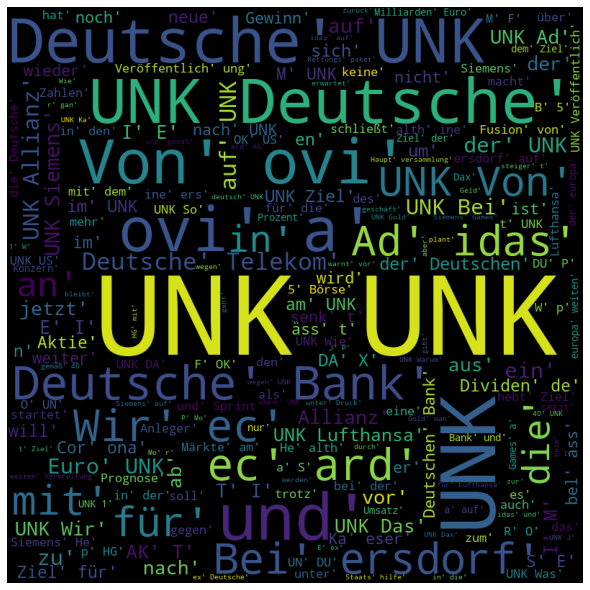

In [ ]:
plot_dataframe(finanzen_net_df, "tokens")

In [ ]:
group1_df = finanzen_net_df[(finanzen_net_df['stock'] == 'beiersdorf') | (finanzen_net_df['stock'] == 'vonovia')]

07/12/2020 10:39:21 - INFO - farm.modeling.tokenization -   Loading tokenizer of type 'BertTokenizer'
07/12/2020 10:39:21 - INFO - transformers.tokenization_utils_base -   loading file https://int-deepset-models-bert.s3.eu-central-1.amazonaws.com/pytorch/bert-base-german-cased-vocab.txt from cache at /root/.cache/torch/transformers/da299cdd121a3d71e1626f2908dda0d02658f42e925a3d6abd8273ec08cf41a6.31ccc255fc2bad3578089a3997f16b286498ba78c0adc43b5bb2a3f9a0d2c85c


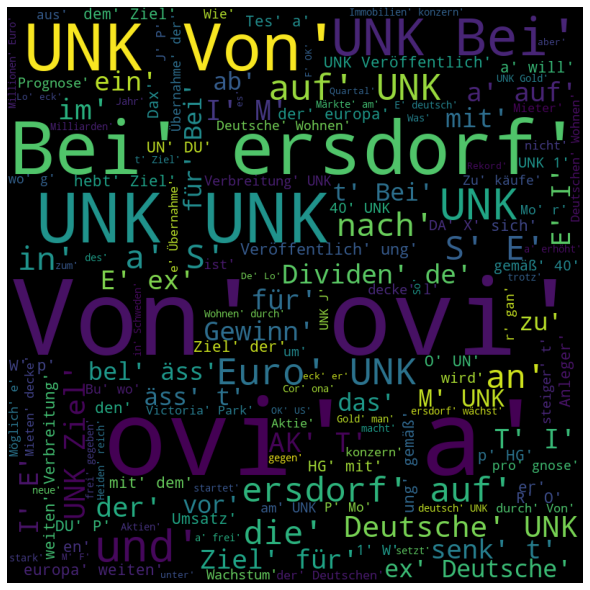

In [ ]:
plot_dataframe(group1_df, "tokens")

# Exploration des deutschen BERT Lexikons

In [ ]:
def show_pretrained_vocab():
  tokenizer = Tokenizer.load(
      pretrained_model_name_or_path="bert-base-german-cased",
      do_lower_case=False)
  for token in tokenizer.vocab:
    print(token)

  counter = {"words":0, "subwords":0, "unused":0}
  for token in tokenizer.vocab:
    if token.find('unused') == True:
      counter['unused'] += 1
    if token.find('##') == 0:
      counter['subwords'] += 1
    else:
      counter['words'] += 1 
  print("------------------------------------------")  
  print("Zusammenfassung")
  for key in counter:
    print("{} : {}".format(key, counter[key]))

In [ ]:
show_pretrained_vocab()

07/12/2020 10:39:23 - INFO - farm.modeling.tokenization -   Loading tokenizer of type 'BertTokenizer'
07/12/2020 10:39:23 - INFO - transformers.tokenization_utils_base -   loading file https://int-deepset-models-bert.s3.eu-central-1.amazonaws.com/pytorch/bert-base-german-cased-vocab.txt from cache at /root/.cache/torch/transformers/da299cdd121a3d71e1626f2908dda0d02658f42e925a3d6abd8273ec08cf41a6.31ccc255fc2bad3578089a3997f16b286498ba78c0adc43b5bb2a3f9a0d2c85c


Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
##langer
Import
profil
Delegierten
umgestaltet
##Verb
##ausweis
Annäherung
freundlich
Finanzgericht
Achsen
meines
angerufen
##mail
Einbruch
bedurfte
Wahlrecht
erfassten
Ingenieure
##icum
##Sender
Tscha
beweg
Tausend
ernähren
spiegelt
Besoldung
verschafft
zustehenden
Kunstakademie
auszugleichen
Timo
erbe
Gauck
Austrag
50,
##fähiger
Propst
Divisin
Sachverhalte
zutreffenden
Dö
550
##Fernseh
Rafael
Sierra
Indiana
##bb
verank
anderweitig
Freitagabend
Unterzeichnung
##ippt
text
Helene
##Junioren
##umstände
Abfluss
sportlich
##dist
##clubs
##gelenk
redet
trieb
Antwer
ehrenamtlichen
##quet
Philippe
inszenierte
##fallende
Algerien
Missions
einstige
Gefangene
##avy
umk
##sperr
Krum
##atiker
##vaters
Lösch
Orange
##ziehende
Zunahme
Landsmann
beschließt
Vergewaltigung
##isi
138
##iaten
##abrechnung
Abtretung
Profession
##jar
##jas
sus
##atory
Shar
kelt
Sitten
dicken
##satzweise
hessische
Kulturdenkmale
##ted
Batt
##Sieger
##schuhe


# Generierung der Stichproben für die manuelle Kennzeichnung

In [ ]:
def create_sample_df(df, sample_size):
  # Geschichtete Zufallsstichprobe
  temp_df = df.copy()
  new_df = pd.DataFrame()
  labels = temp_df['stock'].unique()
  n = int(sample_size / len(labels))
  for label in labels:
    new_df = new_df.append(temp_df[temp_df['stock'] == label].sample(n=n))
  
  return new_df

In [ ]:
sample_df = create_sample_df(finanzen_net_df, 1000)

In [ ]:
sample_df.groupby('stock')['title'].agg(sample_size = "count")

sample_size
stock                        
adidas                    111
allianz                   111
beiersdorf                111
deutsche_bank             111
deutsche_telekom          111
lufthansa                 111
siemens                   111
vonovia                   111
wirecard                  111

In [ ]:
sample_df.to_csv('./drive/My Drive/fom_thesis_wi_2020/sample.csv', sep = ';', line_terminator = '\n', encoding = "utf-8", index = True)

Es folgt die manuelle Kennzeichnung der Stichproben

# Datenvisualisierung der manuellen Kennzeichnungen der Stichproben

In [ ]:
sample_with_label_df = pd.read_csv('./drive/My Drive/fom_thesis_wi_2020/sample_with_label.csv', encoding = 'utf-8', sep=';')

In [ ]:
sample_with_label_df.head()

Unnamed: 0        date sentiment  ...   stock        source token_length
0           0  2019-05-20     other  ...  adidas     EQS Group            5
1           1  2019-11-11     other  ...  adidas          WELT           11
2           2  2019-05-22  positive  ...  adidas  Der Aktionär            8
3           3  2019-10-21     other  ...  adidas     Dow Jones           10
4           4  2020-02-19  negative  ...  adidas         Blick           12

[5 rows x 7 columns]

In [ ]:
def plot_sample(df, variable):
  
  # Temporäre Kopie des Dataframes
  temp_df = df.copy()
 
  if variable == "sentiment":
    # Aggregation der Dimensionen 'stock' und 'source' zum Ermittlung der Anzahl an Nachrichtenartikel
    temp_df = temp_df.groupby(['stock', 'sentiment'])['title'].agg(['count']).reset_index().sort_values('count', ascending=False)
    
    # Erstellung des Balkendiagramms
    fig = px.bar(data_frame = temp_df, 
                 x = 'stock', 
                 y = 'count',
                 #template = pio.templates['plotly_dark'], 
                 color='sentiment',
                 title = "Anzahl der Nachrichtenartikel nach Sentiment Kategorie") 
    
  
  if variable == 'date':
    # Numpy Datetime Format wird in ein Python Datetime umgewandelt
    temp_df['date'] = temp_df['date'].astype('datetime64')
    temp_df['date'] = temp_df['date'].apply(datetime.datetime.date)

    # Breite der Klassen ergibt sich aus dem Betrachtungszeitraum. 1 Tag = 1 Klasse
    bins = temp_df['date'].max() - temp_df['date'].min() 

    # Zeitreihen Diagramm wird erstellt
    fig = px.histogram(data_frame = temp_df, 
                       x = "date", 
                       color = "sentiment", 
                       nbins = bins.days, 
                       #template = pio.templates['plotly_dark'], 
                       title = "Anzahl der Nachrichtenartikel nach Sentiment Kategorie")
  if variable == 'tokens':
    # Wortwolke wird erstellt
    temp_df = add_tokens(temp_df)
    token_list = list()

    for array in temp_df['tokens']:
      token_list += array

    wordcloud = WordCloud(width = 800, 
                          height = 800,
                        min_font_size = 10).generate(str(token_list))

    plt.figure(figsize = (8,8), facecolor=None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0) 

  try:
    fig.show()
  except UnboundLocalError:   
    plt.show() 

In [ ]:
plot_sample(sample_with_label_df, 'sentiment')

In [ ]:
plot_sample(sample_with_label_df, 'date')

# Datenaufbereitung für das Model Training

In [ ]:
sample_with_label_mod_df = sample_with_label_df[['title', 'sentiment']]
sample_with_label_mod_df.columns = ['text', 'sentiment']

In [ ]:
train_df, test_df = train_test_split(sample_with_label_mod_df, test_size=0.33, random_state=42)

In [ ]:
train_df = train_df.copy()
train_df['sentiment'] = train_df['sentiment'].astype('string')
train_df['text'] = train_df['text'].astype('string')

test_df = test_df.copy()
test_df['sentiment'] = test_df['sentiment'].astype('string')
test_df['text'] = test_df['text'].astype('string')


In [ ]:
train_df.to_csv('./drive/My Drive/fom_thesis_wi_2020/train.tsv', sep = '\t', encoding='utf-8', index = False)
test_df.to_csv('./drive/My Drive/fom_thesis_wi_2020/test.tsv', sep = '\t', encoding='utf-8', index = False)

# BERT Modell trainieren

In [ ]:
def sentiment_analysis(batch_size, n_epoch, learning_rate, dropout):
  logging.basicConfig(
            format="%(asctime)s - %(levelname)s - %(name)s -   %(message)s",
            datefmt="%m/%d/%Y %H:%M:%S",
            level=logging.INFO)
  ml_logger = MLFlowLogger(tracking_uri="https://public-mlflow.deepset.ai/")
  ml_logger.init_experiment(experiment_name="FinanzenNetSentiment", 
                              run_name="sentiment_finanzen_net_luisarteaga")

  set_all_seeds(seed=42)
  device, n_gpu = initialize_device_settings(use_cuda=True)
  n_epochs = n_epoch
  batch_size = batch_size

  evaluate_every = 100
  lang_model = "bert-base-german-cased" # https://huggingface.co/transformers/pretrained_models.html
  do_lower_case = True

  tokenizer = Tokenizer.load(
                            pretrained_model_name_or_path = lang_model,
                            do_lower_case = do_lower_case)    

  sentiment = ['positive', 
                 'negative', 
                 'other']
  metric = 'acc'

  processor = TextClassificationProcessor(tokenizer=tokenizer,
                                            max_seq_len=128,
                                            data_dir=Path("./drive/My Drive/fom_thesis_wi_2020/"),
                                            quote_char='"', 
                                            multilabel=False,
                                            train_filename="train.tsv",
                                            test_filename="test.tsv",
                                            dev_filename = None,
                                            label_column_name="sentiment",
                                            label_list=sentiment,
                                            metric=metric                                 
                                            )    
    
  data_silo = DataSilo(processor= processor, batch_size = batch_size)
  language_model = LanguageModel.load(lang_model)
    
  prediction_head = TextClassificationHead(num_labels=len(sentiment))

  def loss_fn(tensors,global_step = None, batch=None):
    #return torch.mean(torch.stack(tensors), dim = 0)
    #print("Tensors: {}".format(str(tensors)))
    #print("Global Step: {}".format(str(global_step)))
    #print("Batch: {}".format(str(batch)))
    return sum(tensors)

  def loss_fn2(tensors, global_step = None, batch = None):
    return torch.sqrt(torch.mean(torch.stack(tensors) ** 2, dim = 0))
    



  model = AdaptiveModel(
        language_model=language_model,
        prediction_heads=[prediction_head],
        embeds_dropout_prob=dropout,
        loss_aggregation_fn = loss_fn2,
        lm_output_types=["per_sequence"],
        device=device)
    
  model, optimizer, lr_schedule = initialize_optimizer(
        model=model,
        learning_rate=learning_rate,
        device=device,
        n_batches=len(data_silo.loaders["train"]),
        n_epochs=n_epochs)
    
  trainer = Trainer(
        model=model,
        optimizer=optimizer,
        data_silo=data_silo,
        epochs=n_epochs,
        n_gpu=n_gpu,
        lr_schedule=lr_schedule,
        evaluate_every=evaluate_every,
        device=device)
    
  trainer.train()

  save_dir = Path('./drive/My Drive/fom_thesis_wi_2020/models/bert-german-mt-tc2')
  model.save(save_dir)
  processor.save(save_dir)


In [ ]:
sentiment_analysis(batch_size=32, n_epoch=3.7, learning_rate=2e-5, dropout=0.1)


 __          __  _                            _        
 \ \        / / | |                          | |       
  \ \  /\  / /__| | ___ ___  _ __ ___   ___  | |_ ___  
   \ \/  \/ / _ \ |/ __/ _ \| '_ ` _ \ / _ \ | __/ _ \ 
    \  /\  /  __/ | (_| (_) | | | | | |  __/ | || (_) |
     \/  \/ \___|_|\___\___/|_| |_| |_|\___|  \__\___/ 
  ______      _____  __  __  
 |  ____/\   |  __ \|  \/  |              _.-^-._    .--.
 | |__ /  \  | |__) | \  / |           .-'   _   '-. |__|
 |  __/ /\ \ |  _  /| |\/| |          /     |_|     \|  |
 | | / ____ \| | \ \| |  | |         /               \  |
 |_|/_/    \_\_|  \_\_|  |_|        /|     _____     |\ |
                                     |    |==|==|    |  |
|---||---|---|---|---|---|---|---|---|    |--|--|    |  |
|---||---|---|---|---|---|---|---|---|    |==|==|    |  |
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
 


06/13/2020 22:14:47 - INFO - farm.utils -   device: cuda n_gpu: 1, distributed training: False, automatic mixed precision training: None
06/13/2020 22:14:47 - INFO - farm.modeling.tokenization -   Loading tokenizer of type 'BertTokenizer'
06/13/2020 22:14:47 - INFO - transformers.tokenization_utils -   loading file https://int-deepset-models-bert.s3.eu-central-1.amazonaws.com/pytorch/bert-base-german-cased-vocab.txt from cache at /root/.cache/torch/transformers/da299cdd121a3d71e1626f2908dda0d02658f42e925a3d6abd8273ec08cf41a6.31ccc255fc2bad3578089a3997f16b286498ba78c0adc43b5bb2a3f9a0d2c85c
06/13/2020 22:14:48 - INFO - farm.data_handler.data_silo -   
Loading data into the data silo ... 
              ______
               |o  |   !
   __          |:`_|---'-.
  |__|______.-/ _ \-----.|       
 (o)(o)------'\ _ /     ( )      
 
06/13/2020 22:14:48 - INFO - farm.data_handler.data_silo -   Loading train set from: drive/My Drive/fom_thesis_wi_2020/train.tsv 
06/13/2020 22:14:48 - INFO - far

In [ ]:
# Leert den Cache der GPU
torch.cuda.empty_cache()

# Sentimentanalyse der Finanzen.net Nachrichtentitel

In [ ]:
finanzen_net_df = pd.read_feather('./drive/My Drive/fom_thesis_wi_2020/finanzen_net_df.feather')

In [ ]:
def text_dict(df):
  temp_df = df.copy()
  temp_df['dict_text'] = temp_df['title'].apply(lambda x: {"text": x})

  return temp_df

In [ ]:
finanzen_net_df = text_dict(finanzen_net_df)

In [ ]:
finanzen_net_df.head()

date  ...                                          dict_text
0 2019-06-07  ...  {'text': 'Vertragsstreit mit Spanien: Adidas g...
1 2019-05-31  ...  {'text': 'So schätzen die Analysten die adidas...
2 2019-05-29  ...  {'text': 'Adidas: Das ist in 24 Jahren aus 10....
3 2019-05-27  ...       {'text': 'Adidas: Geht der Irrsinn weiter?'}
4 2019-05-27  ...  {'text': 'Citi: Adidas - Von einem Allzeithoch...

[5 rows x 6 columns]

In [ ]:
def add_sentiment(df):
  temp_df = df.copy()
  
  def predict_sentiment(df):
    model = Inferencer.load(Path('./drive/My Drive/fom_thesis_wi_2020/models/bert-german-mt-tc2'), 
                            num_processes=4, 
                            gpu=True,
                            task_type='text_classification')
    text_dict = list()
    for line in df['dict_text']:
      text_dict.append(line)
    
    results = model.inference_from_dicts(dicts=text_dict, multiprocessing_chunksize=32)

    return results
  
  results = predict_sentiment(temp_df)
  sentiment = list()
  prob = list()
  for i in range(len(results)):
    for j in range(len(results[i]['predictions'])):
      sentiment.append(results[i]['predictions'][j]['label'])
      prob.append(results[i]['predictions'][j]['probability'])
  temp_df['sentiment'] = sentiment
  temp_df['probability'] = prob

  return temp_df

In [ ]:
finanzen_net_with_sentiment_df = add_sentiment(finanzen_net_df)

06/13/2020 22:25:59 - INFO - farm.utils -   device: cuda n_gpu: 1, distributed training: False, automatic mixed precision training: None
06/13/2020 22:25:59 - INFO - transformers.modeling_utils -   loading weights file drive/My Drive/fom_thesis_wi_2020/models/bert-german-mt-tc2/language_model.bin from cache at drive/My Drive/fom_thesis_wi_2020/models/bert-german-mt-tc2/language_model.bin
06/13/2020 22:26:02 - INFO - farm.modeling.adaptive_model -   Found files for loading 1 prediction heads
06/13/2020 22:26:02 - WARNING - farm.modeling.prediction_head -   `layer_dims` will be deprecated in future releases
06/13/2020 22:26:02 - INFO - farm.modeling.prediction_head -   Prediction head initialized with size [768, 3]
06/13/2020 22:26:02 - INFO - farm.modeling.prediction_head -   Loading prediction head from drive/My Drive/fom_thesis_wi_2020/models/bert-german-mt-tc2/prediction_head_0.bin
06/13/2020 22:26:03 - WARNING - farm.utils -   Failed to log params: INVALID_PARAMETER_VALUE: Changing 

In [ ]:
finanzen_net_with_sentiment_df = finanzen_net_with_sentiment_df[['date', 'title', 'stock', 'source', 'token_length','sentiment', 'probability']].copy()

In [ ]:
finanzen_net_with_sentiment_df.head(5)

date  ... probability
0 2019-06-07  ...    0.910203
1 2019-05-31  ...    0.862432
2 2019-05-29  ...    0.950091
3 2019-05-27  ...    0.864694
4 2019-05-27  ...    0.680637

[5 rows x 7 columns]

In [ ]:
finanzen_net_with_sentiment_df.to_feather('./drive/My Drive/fom_thesis_wi_2020/finanzen_net_with_sentiment_df.feather')

# Datenvisualisierung der Sentiments nach Aktie und Zeit

In [ ]:
finanzen_net_with_sentiment_df = pd.read_feather('./drive/My Drive/fom_thesis_wi_2020/finanzen_net_with_sentiment_df.feather')

In [ ]:
finanzen_net_with_sentiment_df.head()

date  ... probability
0 2019-06-07  ...    0.910203
1 2019-05-31  ...    0.862432
2 2019-05-29  ...    0.950091
3 2019-05-27  ...    0.864694
4 2019-05-27  ...    0.680637

[5 rows x 7 columns]

In [ ]:
test2_df = finanzen_net_with_sentiment_df[(finanzen_net_with_sentiment_df['stock'] != 'lufthansa') & (finanzen_net_with_sentiment_df['date'] > '2018-01-01 00:00:00')]

In [ ]:
test2_df['date'].min()

Timestamp('2018-01-03 00:00:00')

In [ ]:
plot_sample(test2_df, "sentiment")

In [ ]:
test2_df.head()

date  ... probability
0 2019-06-07  ...    0.910203
1 2019-05-31  ...    0.862432
2 2019-05-29  ...    0.950091
3 2019-05-27  ...    0.864694
4 2019-05-27  ...    0.680637

[5 rows x 7 columns]

In [ ]:
group1_df = test2_df.query('stock == "vonovia" | stock == "beiersdorf"')

In [ ]:
group1_df

date  ... probability
1500 2020-03-04  ...    0.980258
1501 2020-03-04  ...    0.980239
1502 2020-03-03  ...    0.779173
1503 2020-03-03  ...    0.720854
1504 2020-03-03  ...    0.806905
...         ...  ...         ...
6412 2019-06-04  ...    0.933147
6413 2019-06-03  ...    0.616835
6414 2019-05-31  ...    0.895128
6415 2019-05-24  ...    0.832215
6416 2019-05-24  ...    0.836534

[1038 rows x 7 columns]

In [ ]:
plot_sample(group1_df, 'date')

In [ ]:
test2_df['share_negative_sentiment'] = p['score']/test2_df['sentiment'].count()

In [ ]:
test2_df.groupby(['stock','sentiment']).agg(['count'])

date title source token_length probability
                           count count  count        count       count
stock            sentiment                                            
adidas           negative    197   197    197          197         197
                 other       151   151    151          151         151
                 positive    238   238    238          238         238
allianz          negative    219   219    219          219         219
                 other       234   234    234          234         234
                 positive    461   461    461          461         461
beiersdorf       negative    150   150    150          150         150
                 other        71    71     71           71          71
                 positive    204   204    204          204         204
deutsche_bank    negative    505   505    505          505         505
                 other       118   118    118          118         118
                 positive    282   282    282          282         282
deutsche_telekom negative    254   254    254          254         254
                 other       272   272    272          272         272
                 positive    392   392    392          392         392
siemens          negative    317   317    317          317         317
                 other       275   275    275          275         275
                 positive    330   330    330          330         330
vonovia          negative     90    90     90           90          90
                 other       211   211    211          211         211
                 positive    312   312    312          312         312
wirecard         negative    214   214    214          214         214
                 other       279   279    279          279         279
                 positive    291   291    291          291         291

In [ ]:
wirecard_news = finanzen_net_with_sentiment_df[finanzen_net_with_sentiment_df['stock'] == 'wirecard']

In [ ]:
plot_sample(wirecard_news, 'date')

# Datenvisualisierung der Sentimentanalyse

In [ ]:
plot_sample(finanzen_net_with_sentiment_df, "sentiment")

In [ ]:
plot_sample(finanzen_net_with_sentiment_df, 'date')

07/12/2020 14:36:19 - INFO - farm.modeling.tokenization -   Loading tokenizer of type 'BertTokenizer'
07/12/2020 14:36:19 - INFO - transformers.tokenization_utils_base -   loading file https://int-deepset-models-bert.s3.eu-central-1.amazonaws.com/pytorch/bert-base-german-cased-vocab.txt from cache at /root/.cache/torch/transformers/da299cdd121a3d71e1626f2908dda0d02658f42e925a3d6abd8273ec08cf41a6.31ccc255fc2bad3578089a3997f16b286498ba78c0adc43b5bb2a3f9a0d2c85c


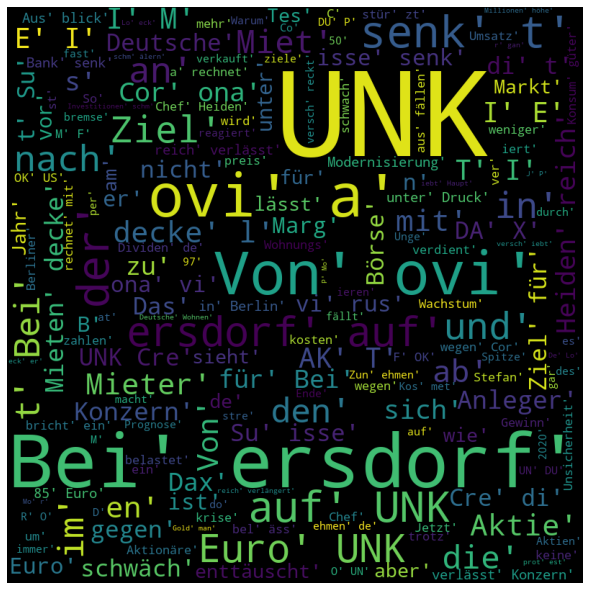

In [ ]:
plot_sample(group1_df.query('sentiment == "negative"'),'tokens')

07/12/2020 14:36:44 - INFO - farm.modeling.tokenization -   Loading tokenizer of type 'BertTokenizer'
07/12/2020 14:36:44 - INFO - transformers.tokenization_utils_base -   loading file https://int-deepset-models-bert.s3.eu-central-1.amazonaws.com/pytorch/bert-base-german-cased-vocab.txt from cache at /root/.cache/torch/transformers/da299cdd121a3d71e1626f2908dda0d02658f42e925a3d6abd8273ec08cf41a6.31ccc255fc2bad3578089a3997f16b286498ba78c0adc43b5bb2a3f9a0d2c85c


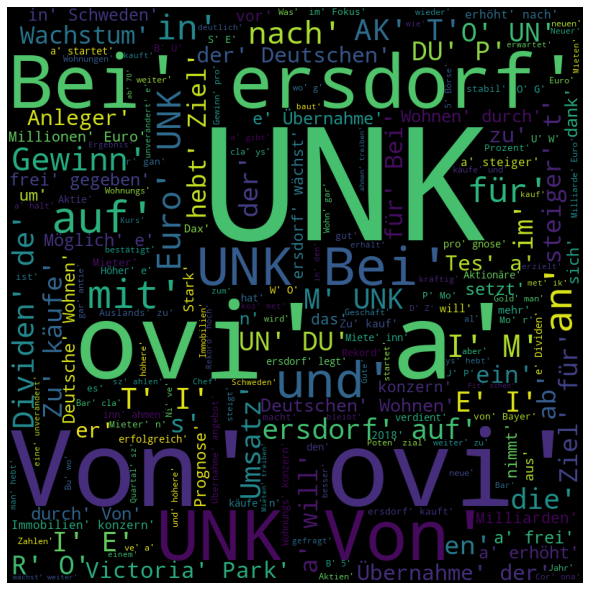

In [ ]:
plot_sample(group1_df.query('sentiment == "positive"'),'tokens')

In [ ]:
positive_sentiment = finanzen_net_with_sentiment_df[finanzen_net_with_sentiment_df['sentiment'] == 'positive']
negative_sentiment = finanzen_net_with_sentiment_df[finanzen_net_with_sentiment_df['sentiment'] == 'negative']
other_sentiment = finanzen_net_with_sentiment_df[finanzen_net_with_sentiment_df['sentiment'] == 'other']

06/13/2020 22:46:35 - INFO - farm.modeling.tokenization -   Loading tokenizer of type 'BertTokenizer'
06/13/2020 22:46:35 - INFO - transformers.tokenization_utils -   loading file https://int-deepset-models-bert.s3.eu-central-1.amazonaws.com/pytorch/bert-base-german-cased-vocab.txt from cache at /root/.cache/torch/transformers/da299cdd121a3d71e1626f2908dda0d02658f42e925a3d6abd8273ec08cf41a6.31ccc255fc2bad3578089a3997f16b286498ba78c0adc43b5bb2a3f9a0d2c85c


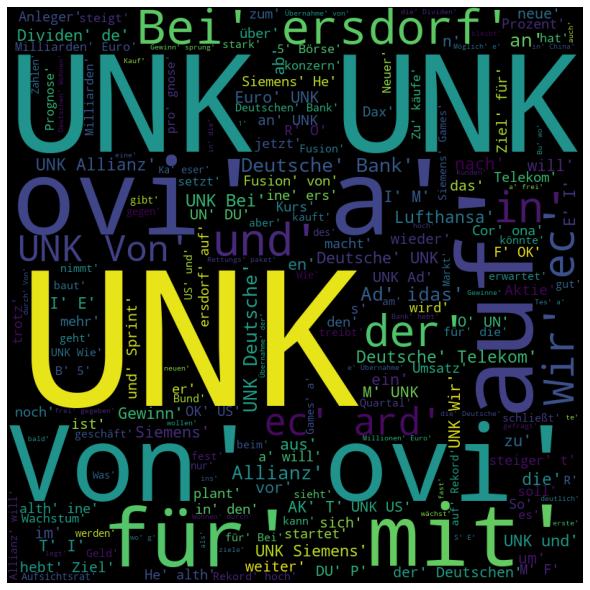

In [ ]:
plot_sample(positive_sentiment, 'tokens')

06/13/2020 22:59:41 - INFO - farm.modeling.tokenization -   Loading tokenizer of type 'BertTokenizer'
06/13/2020 22:59:42 - INFO - transformers.tokenization_utils -   loading file https://int-deepset-models-bert.s3.eu-central-1.amazonaws.com/pytorch/bert-base-german-cased-vocab.txt from cache at /root/.cache/torch/transformers/da299cdd121a3d71e1626f2908dda0d02658f42e925a3d6abd8273ec08cf41a6.31ccc255fc2bad3578089a3997f16b286498ba78c0adc43b5bb2a3f9a0d2c85c


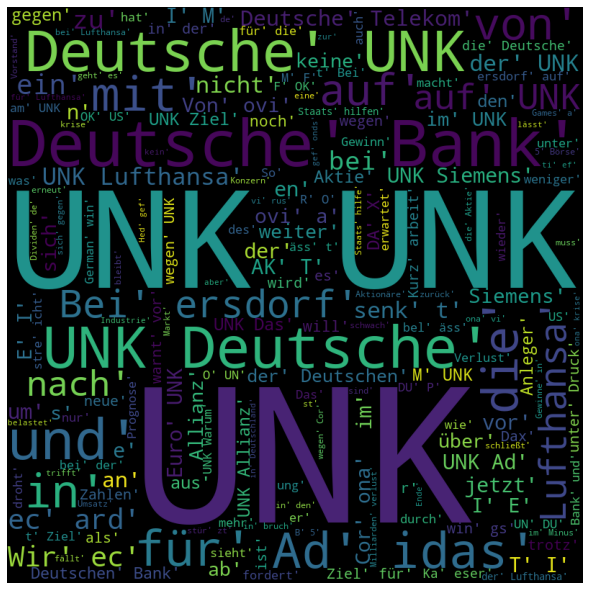

In [ ]:
plot_sample(negative_sentiment, 'tokens')

In [ ]:
positive_sentiment.iloc[:,1]

6       Modehersteller Tommy Hilfiger will Adidas Konk...
8       WDH/ANALYSE-FLASH: Baader Bank hebt Ziel für A...
9       ANALYSE-FLASH: Baader Bank hebt Ziel für Adida...
10      Adidas: Zweite Chance? Bei dieser Marke wird e...
11              B5 Börse 17.14 Uhr: Adidas auf Rekordkurs
                              ...                        
7195    Endspurt zur Weihnachtszeit: "Apple, Wirecard ...
7196    OTS: Wirecard AG / Wirecard gewinnt GetYourGui...
7197    Wirecard: Diese Bullen setzen auf das Comeback...
7198    Zahlungsdienstleister: Markus Braun erwartet ...
7199    Fondsgesellschaft DWS kauft massiv Wirecard-Ak...
Name: title, Length: 2924, dtype: object

In [ ]:
negative_sentiment.iloc[:,1]

0       Vertragsstreit mit Spanien: Adidas geht gegen ...
3                        Adidas: Geht der Irrsinn weiter?
15              Adidas, Nike und Puma appelieren an Trump
16                                 Adidas: Katastrophal"
24      WDH/ROUNDUP: Adidas glänzt im Jubiläumsjahr - ...
                              ...                        
7155    Singapur-Keule lässt Wirecard-Aktie nachbörsli...
7156    Zahlungsdienstleister: Weitere Unregelmäßigkei...
7177    NACHBÖRSE/XDAX +0,5% auf 13.449 Pkt - Wirecard...
7191                        Wirecard wird wieder belastet
7192    DAX eröffnet eröffnet kaum verändert: DAX-Anle...
Name: title, Length: 2498, dtype: object

In [ ]:
# Source und Sentiment

# Master DataFrame Code

In [ ]:
def create_master_dataframe(stock_name, start_date, end_date):
  dax_stocks = dict(adidas="ADS.DE", allianz="ALV.DE", beiersdorf="BEI.DE", 
                    deutsche_bank="DBK.DE", lufthansa="LHA.DE",
                    deutsche_telekom="DTE.DE", siemens="SIE.DE", volkswagen="VOW3.DE",
                    vonovia="VNA.DE", wirecard="WDI.DE")
  stock_id = dax_stocks[stock_name]
  observation_period = pd.date_range(start=start_date, end = end_date, freq='D')
  date_df = pd.DataFrame(data=observation_period, columns = ['Date'])
  yf_df = yf.Ticker(stock_id).history(start=start_date, end=end_date)
  stock_df = pd.merge(left = date_df, right = yf_df, how = 'left', on = 'Date')
  sentiment_df = pd.read_feather('./drive/My Drive/fom_thesis_wi_2020/finanzen_net_with_sentiment_df.feather')
  # Duplikate entfernen
  sentiment_df = sentiment_df.drop_duplicates(subset=['date','title','stock'])
  stock_sentiment_df = sentiment_df[sentiment_df['stock'] == stock_name].copy()

  def transform_sentiment_df(df):
    temp_df = df[['date', 'sentiment']].copy()
    temp_df = temp_df.groupby('date').apply(lambda x: pd.Series(dict(
      total_positive_news_sentiment = (x['sentiment'] == 'positive').sum(),
      total_negative_news_sentiment = (x['sentiment'] == 'negative').sum(),
      total_neutral_news_sentiment = (x['sentiment'] == 'other').sum(),
      total_news_sentiment = x['sentiment'].count())))
  
    return temp_df
  
  stock_sentiment_df = transform_sentiment_df(stock_sentiment_df)
  temp_df = pd.merge(left = stock_df, 
                     right = stock_sentiment_df, 
                     how = 'left', 
                     left_on='Date', 
                     right_on='date')
  
  #temp_df['total_positive_news_sentiment'] = temp_df['total_positive_news_sentiment'].astype('int32')
  #temp_df['total_negative_news_sentiment'] = temp_df['total_negative_news_sentiment'].astype('int32')
  #temp_df['total_neutral_news_sentiment'] = temp_df['total_neutral_news_sentiment'].astype('int32')
  #temp_df['total_news_sentiment'] = temp_df['total_news_sentiment'].astype('int32')
  
  temp_df.rename(columns = {'Date':'date',
                            'Open':'stock_price_open',
                            'High':'stock_price_high',
                            'Low': 'stock_price_low',
                            'Close': 'stock_price_close',
                            'Volume': 'stock_trading_volume'},
                 inplace = True)
  temp_df['stock_name'] = stock_name
  temp_df = temp_df[['date', 
                     'stock_price_open', 
                     'stock_price_high', 
                     'stock_price_low', 'stock_price_close',
                     'stock_trading_volume', 
                     'total_positive_news_sentiment',
                     'total_negative_news_sentiment',
                     'total_neutral_news_sentiment',
                     'total_news_sentiment',
                     'stock_name']].copy()
  temp_df['stock_price_close_ffill'] = temp_df['stock_price_close'].fillna(method='ffill')
  temp_df.iloc[0,11] = temp_df.iloc[1,11]
  temp_df['total_positive_news_sentiment'].fillna(0, inplace=True)
  temp_df['total_negative_news_sentiment'].fillna(0, inplace=True)
  temp_df['total_neutral_news_sentiment'].fillna(0, inplace=True)
  temp_df['total_news_sentiment'].fillna(0, inplace=True)
  temp_df['stock_trading_volume'].fillna(0, inplace=True)

  return temp_df

# Code zur Datenvisualisierung der Aktienkurse

In [ ]:
def plot_stock_data(df, variable=None):
  temp_df = df.copy()
  
  # Create figure with secondary y-axis
  fig = make_subplots(specs=[[{"secondary_y": True}]])
  
  if variable is None:
   fig.add_trace(
          go.Scatter(x=temp_df['date'], y=temp_df['stock_price_close'], 
                    name="Stock Price (Close)",
                    mode='lines'),
          secondary_y=False    
      )
   
   fig.add_trace(
        go.Bar(x=temp_df['date'], y=df['stock_trading_volume'], 
              name = 'Stock Trading Volume'),
        secondary_y=True
    )

    # Add figure title
   fig.update_layout(
        title_text="{}: Stock Price vs. Stock Trading Volume".format(temp_df['stock_name'].unique()[0]),
        template = pio.templates['plotly_dark']
    )

    # Set x-axis title
   fig.update_xaxes(title_text="Date")

    # Set y-axes titles
   fig.update_yaxes(title_text="<b>Stock Price</b>", secondary_y=False)
   fig.update_yaxes(title_text="<b>Stock Trading Volume</b>", secondary_y=True)



  if variable in ['stock_price', 'stock_trading_volume']:
    if variable == 'stock_price':
      # Add traces
      fig.add_trace(
          go.Scatter(x=temp_df['date'], y=temp_df['stock_price_close'], 
                    name="Stock Price (Close)",
                    mode='lines'),
          secondary_y=False    
      )
      y_axis_name_left = 'Stock Price'

    if variable == 'stock_trading_volume':
      fig.add_trace(
          go.Scatter(x=temp_df['date'], y=temp_df['stock_trading_volume'], 
                    name="Stock Trading Volume",
                    mode='lines'),
          secondary_y=False
      )
      y_axis_name_left = 'Stock Trading Volumen'



    fig.add_trace(
        go.Bar(x=temp_df['date'], y=df['total_positive_news_sentiment'], 
              name = 'Positive News Sentiment'),
        secondary_y=True
    )

    
    fig.add_trace(
        go.Bar(x=temp_df['date'], y=df['total_negative_news_sentiment'], name = 'Negative News Sentiment'),
        secondary_y=True
    )

    
    fig.add_trace(
        go.Bar(x=temp_df['date'], y=df['total_neutral_news_sentiment'], name = 'Neutral News Sentiment'),
        secondary_y=True
    )

    # Add figure title
    fig.update_layout(
        title_text="{}: {} vs. News Sentiment".format(temp_df['stock_name'].unique()[0], 
                                                      y_axis_name_left),
        barmode='stack',
        template = pio.templates['plotly_dark']
    )

    # Set x-axis title
    fig.update_xaxes(title_text="Date")

    # Set y-axes titles
    fig.update_yaxes(title_text="<b>{}</b>".format(y_axis_name_left), secondary_y=False)
    fig.update_yaxes(title_text="<b>Number of News Articles</b>", secondary_y=True)

  fig.show()

# Erstellung von Master Data Frames

In [ ]:
def create_complete_dataset():
  stock_names_list = ['adidas', 'allianz', 'beiersdorf', 
                      'deutsche_bank', 'lufthansa',
                      'deutsche_telekom', 'siemens', 
                      #'volkswagen',
                      'vonovia', 'wirecard']
  for name in stock_names_list:
    test_df = create_master_dataframe(stock_name = name, start_date='2018-01-01', end_date='2020-06-01')
    test_df.to_feather('./drive/My Drive/fom_thesis_wi_2020/{}.feather'.format(name))

In [ ]:
create_complete_dataset()

06/20/2020 14:15:53 - INFO - numexpr.utils -   NumExpr defaulting to 2 threads.


# Beispiel: Adidas

In [ ]:
adidas_df = pd.read_feather('./drive/My Drive/fom_thesis_wi_2020/adidas.feather')

In [ ]:
plot_stock_data(adidas_df ,variable = 'stock_price')

# Datenaufbereitung für Vonovia DataFrame

In [ ]:
vonovia_df = create_master_dataframe(stock_name = 'vonovia', start_date='2018-01-01', end_date='2020-06-01')

In [ ]:
vonovia_df

date  stock_price_open  ...  stock_name  stock_price_close_ffill
0   2018-01-01               NaN  ...     vonovia                    37.14
1   2018-01-02             37.74  ...     vonovia                    37.14
2   2018-01-03             37.20  ...     vonovia                    38.00
3   2018-01-04             38.26  ...     vonovia                    37.93
4   2018-01-05             38.01  ...     vonovia                    38.11
..         ...               ...  ...         ...                      ...
878 2020-05-28             50.56  ...     vonovia                    51.96
879 2020-05-29             51.72  ...     vonovia                    51.78
880 2020-05-30               NaN  ...     vonovia                    51.78
881 2020-05-31               NaN  ...     vonovia                    51.78
882 2020-06-01               NaN  ...     vonovia                    51.78

[883 rows x 12 columns]

In [ ]:
vonovia_df.to_feather('./drive/My Drive/fom_thesis_wi_2020/vonovia.feather')

# Beispiel: Vonovia - Sentiment vs. Aktienkurs vs. Trading Volumen

In [ ]:
vonovia_df

06/15/2020 12:52:22 - INFO - numexpr.utils -   NumExpr defaulting to 2 threads.


In [ ]:
vonovia_df.tail(5)

date  stock_price_open  ...  total_news_sentiment  stock_name
513 2020-05-28             50.56  ...                   NaN     vonovia
514 2020-05-29             51.72  ...                   NaN     vonovia
515 2020-05-30               NaN  ...                   NaN     vonovia
516 2020-05-31               NaN  ...                   NaN     vonovia
517 2020-06-01               NaN  ...                   NaN     vonovia

[5 rows x 11 columns]

In [ ]:
plot_stock_data(vonovia_df, 'stock_price')

In [ ]:
plot_stock_data(vonovia_df, 'stock_trading_volume')

In [ ]:
plot_stock_data(vonovia_df)

# Archiv

In [ ]:
# R Sprache aktivieren
%load_ext rpy2.ipython

/usr/local/lib/python3.6/dist-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning:

pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.

/usr/local/lib/python3.6/dist-packages/rpy2/robjects/pandas2ri.py:34: UserWarning:

pandas >= 1.0 is not supported.



In [ ]:
# Fehlende Pakete installieren
%%R
devtools::install_github("wesm/feather/R")


In [ ]:
%%R
install.packages("bsts")

06/15/2020 13:11:01 - WARNING - rpy2.rinterface_lib.callbacks -   R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

06/15/2020 13:11:02 - WARNING - rpy2.rinterface_lib.callbacks -   R[write to console]: also installing the dependencies ‘BoomSpikeSlab’, ‘Boom’


06/15/2020 13:11:02 - WARNING - rpy2.rinterface_lib.callbacks -   R[write to console]: trying URL 'https://cran.rstudio.com/src/contrib/BoomSpikeSlab_1.2.3.tar.gz'

06/15/2020 13:11:02 - WARNING - rpy2.rinterface_lib.callbacks -   R[write to console]: Content type 'application/x-gzip'
06/15/2020 13:11:02 - WARNING - rpy2.rinterface_lib.callbacks -   R[write to console]:  length 128858 bytes (125 KB)

06/15/2020 13:11:02 - WARNING - rpy2.rinterface_lib.callbacks -   R[write to console]: =
06/15/2020 13:11:02 - WARNING - rpy2.rinterface_lib.callbacks -   R[write to console]: =
06/15/2020 13:11:02 - WARNING - rpy2.rinterface_lib.callbacks -   R[write to console]: =
06/15/2020 13

In [ ]:
%%R
library(feather)
library(bsts)
library(tidyverse)
library(lubridate)

06/15/2020 13:04:23 - WARNING - rpy2.rinterface_lib.callbacks -   R[write to console]: Error in library(bsts) : there is no package called ‘bsts’
Calls: <Anonymous> -> <Anonymous> -> withVisible -> library

06/15/2020 13:04:23 - WARNING - rpy2.rinterface_lib.callbacks -   R[write to console]: In addition: 
06/15/2020 13:04:23 - WARNING - rpy2.rinterface_lib.callbacks -   R[write to console]: Warning messages:

06/15/2020 13:04:23 - WARNING - rpy2.rinterface_lib.callbacks -   R[write to console]: 1: 
06/15/2020 13:04:23 - WARNING - rpy2.rinterface_lib.callbacks -   R[write to console]: In install.packages("bsts") :
06/15/2020 13:04:23 - WARNING - rpy2.rinterface_lib.callbacks -   R[write to console]: 
 
06/15/2020 13:04:23 - WARNING - rpy2.rinterface_lib.callbacks -   R[write to console]:  installation of package ‘Boom’ had non-zero exit status

06/15/2020 13:04:23 - WARNING - rpy2.rinterface_lib.callbacks -   R[write to console]: 2: 
06/15/2020 13:04:23 - WARNING - rpy2.rinterface_lib.


Error in library(bsts) : there is no package called ‘bsts’
Calls: <Anonymous> -> <Anonymous> -> withVisible -> library


In [ ]:
%%R
vonovia_r_df <- feather::read_feather("./drive/My Drive/fom_thesis_wi_2020/vonovia.feather") %>$

In [ ]:
%%R

In [ ]:
%%R
vonovia_r_df

# A tibble: 518 x 11
   date                stock_price_open stock_price_high stock_price_low
   <dttm>                         <dbl>            <dbl>           <dbl>
 1 2019-01-01 00:00:00             NA               NA              NA  
 2 2019-01-02 00:00:00             37.1             37.7            37  
 3 2019-01-03 00:00:00             37.4             37.7            37.1
 4 2019-01-04 00:00:00             37.8             38.1            37.4
 5 2019-01-05 00:00:00             NA               NA              NA  
 6 2019-01-06 00:00:00             NA               NA              NA  
 7 2019-01-07 00:00:00             38.1             38.1            37.8
 8 2019-01-08 00:00:00             38.1             38.4            38.0
 9 2019-01-09 00:00:00             38.4             38.4            37.6
10 2019-01-10 00:00:00             37.8             38.2            37.7
# … with 508 more rows, and 7 more variables: stock_price_close <dbl>,
#   stock_trading_volume <dbl>, 

## Bayesian Structural Time Series mit Python

In [ ]:
print(tf.__version__)
print(tfp.__version__)

2.2.0
0.10.0


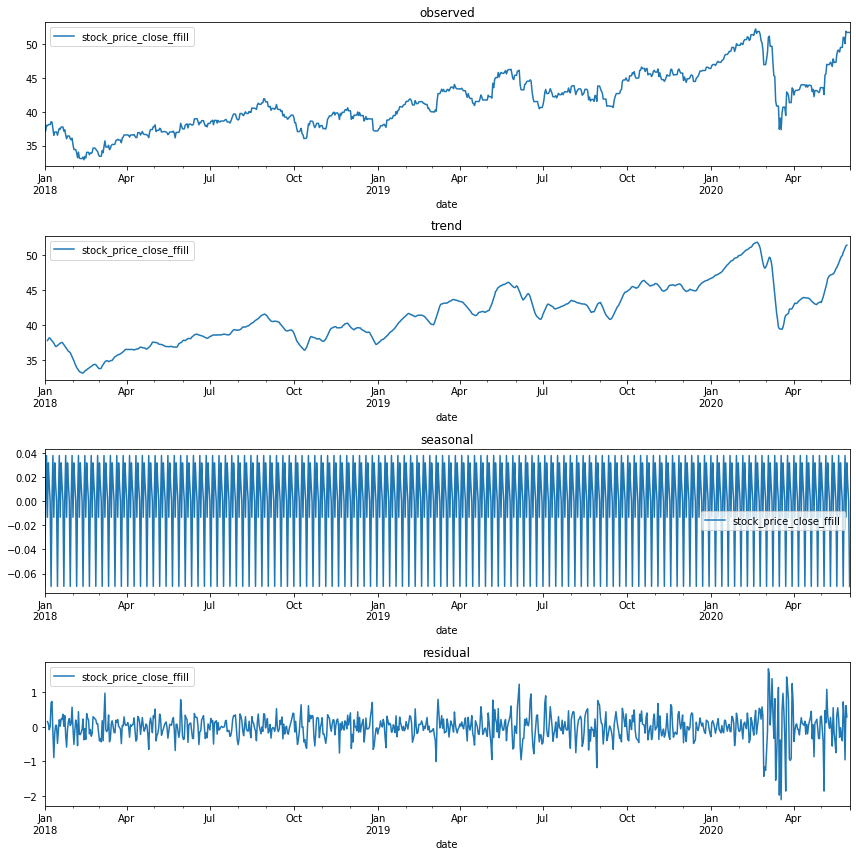

In [ ]:
# Before split Train and Test set

decomposition_obj = seasonal_decompose(
    x=vonovia_df[['date', 'stock_price_close_ffill']].set_index('date'), 
    model='additive'
)

fig, ax = plt.subplots(4, 1, figsize=(12, 12))

decomposition_obj.observed.plot(ax=ax[0])
ax[0].set(title='observed')
decomposition_obj.trend.plot(ax=ax[1])
ax[1].set(title='trend')
decomposition_obj.seasonal.plot(ax=ax[2])
ax[2].set(title='seasonal')
decomposition_obj.resid.plot(ax=ax[3])
ax[3].set(title='residual')
plt.tight_layout()

## Dekomposition der Zeitreihen

In [ ]:
def plot_decomposition(df):

  decomposition_obj = seasonal_decompose(
      x=df[['date', 'stock_price_close_ffill']].set_index('date'),
      model='additive',
      freq=252
  )

  fig, ax = plt.subplots(4, 1, figsize=(12, 12))

  decomposition_obj.observed.plot(ax=ax[0])
  ax[0].set(title='observed')
  decomposition_obj.trend.plot(ax=ax[1])
  ax[1].set(title='trend')
  decomposition_obj.seasonal.plot(ax=ax[2])
  ax[2].set(title='seasonal')
  decomposition_obj.resid.plot(ax=ax[3])
  ax[3].set(title='residual')
  plt.tight_layout()

In [ ]:
adidas = create_master_dataframe(stock_name = 'adidas', start_date='2018-01-01', end_date='2020-06-01')
allianz = create_master_dataframe(stock_name = 'allianz', start_date='2018-01-01', end_date='2020-06-01')
beiersdorf = create_master_dataframe(stock_name = 'beiersdorf', start_date='2018-01-01', end_date='2020-06-01')
lufthansa = create_master_dataframe(stock_name = 'lufthansa', start_date='2018-01-01', end_date='2020-06-01')
deutsche_bank = create_master_dataframe(stock_name = 'deutsche_bank', start_date='2018-01-01', end_date='2020-06-01')
deutsche_telekom = create_master_dataframe(stock_name = 'deutsche_telekom', start_date='2018-01-01', end_date='2020-06-01')
siemens = create_master_dataframe(stock_name = 'siemens', start_date='2018-01-01', end_date='2020-06-01')
vonovia = create_master_dataframe(stock_name = 'vonovia', start_date='2018-01-01', end_date='2020-06-01')
wirecard = create_master_dataframe(stock_name = 'wirecard', start_date='2018-01-01', end_date='2020-06-01')

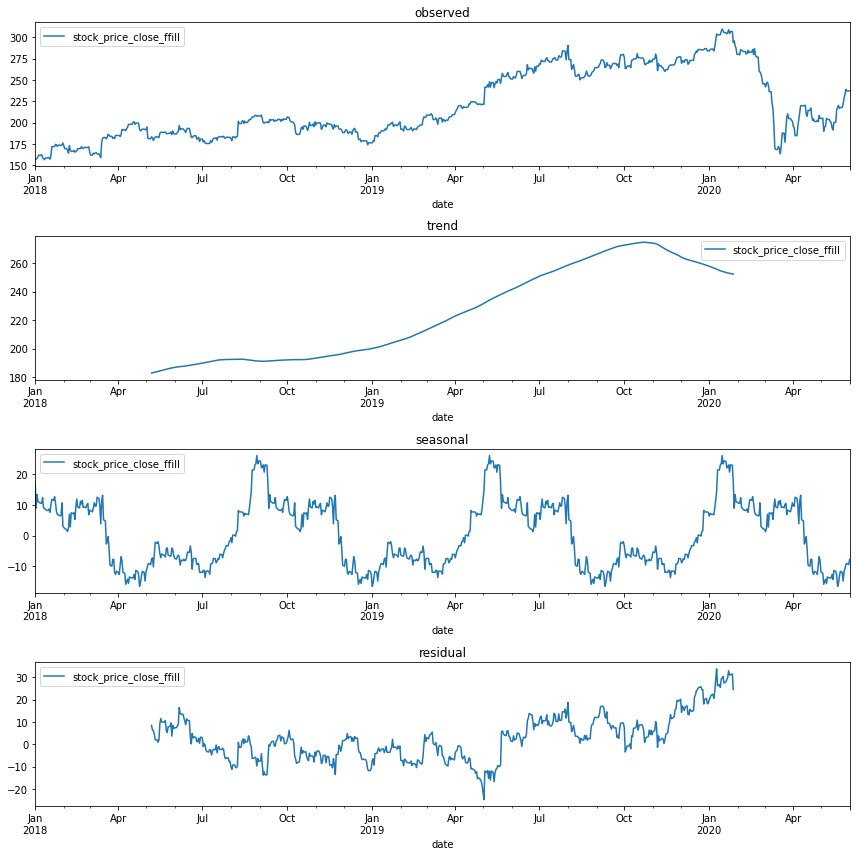

In [ ]:
plot_decomposition(adidas)

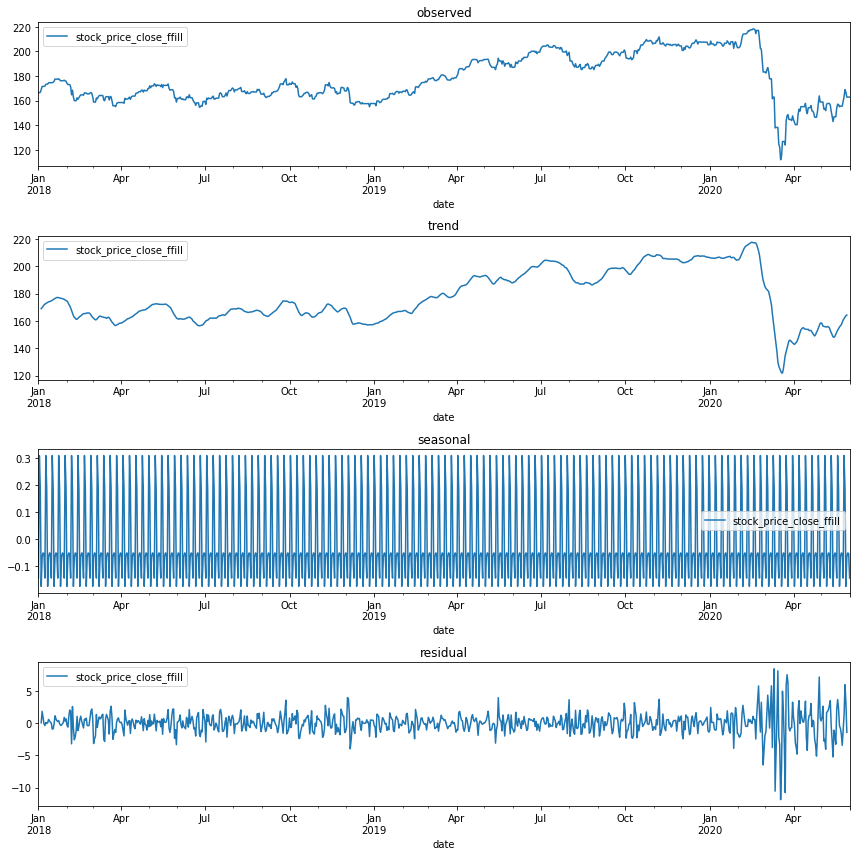

In [ ]:
plot_decomposition(allianz)

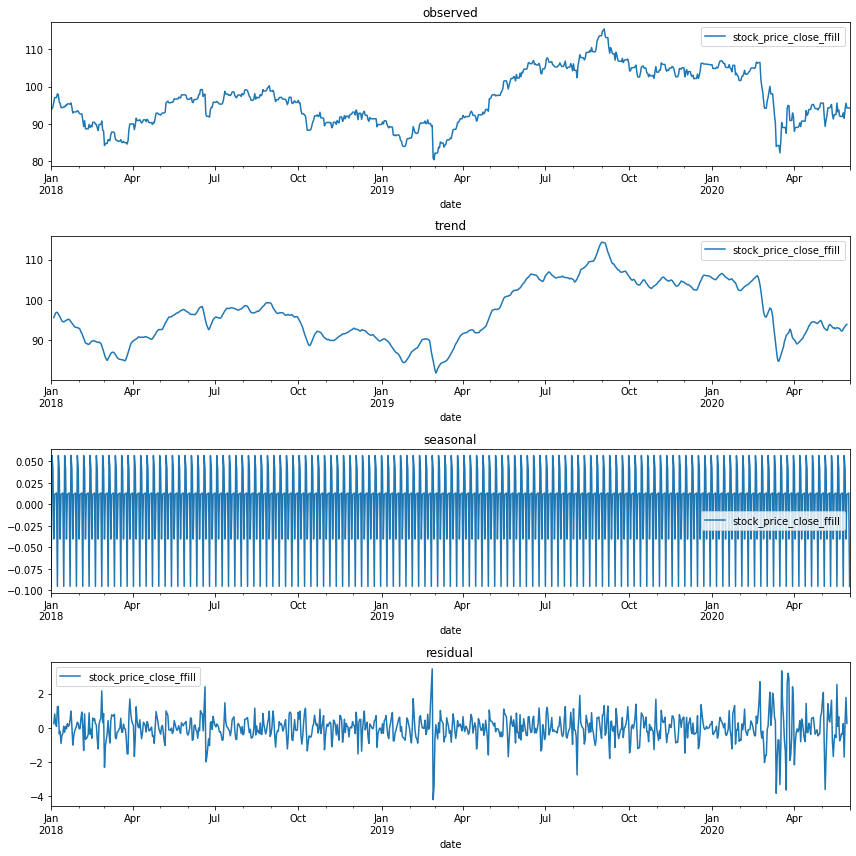

In [ ]:
plot_decomposition(beiersdorf)

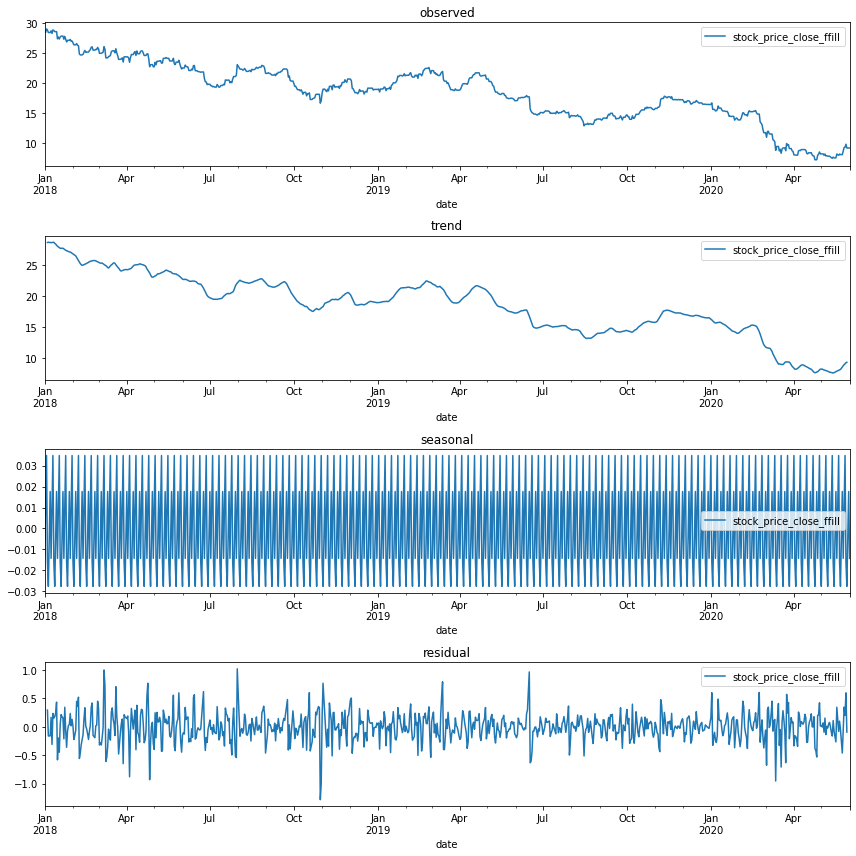

In [ ]:
plot_decomposition(lufthansa)

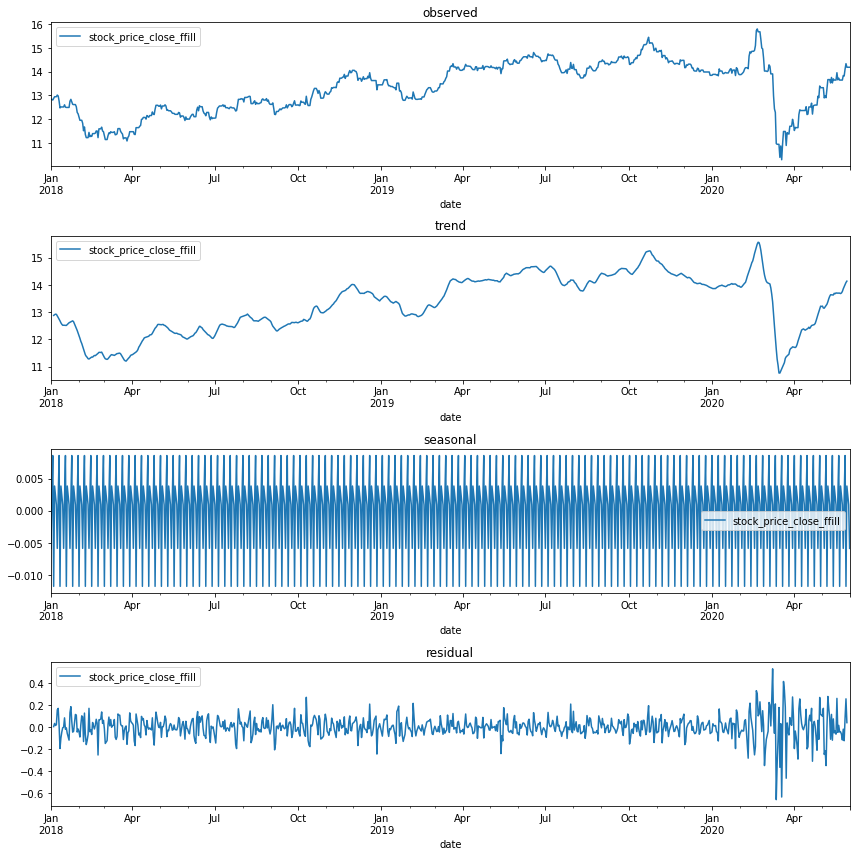

In [ ]:
plot_decomposition(deutsche_telekom)

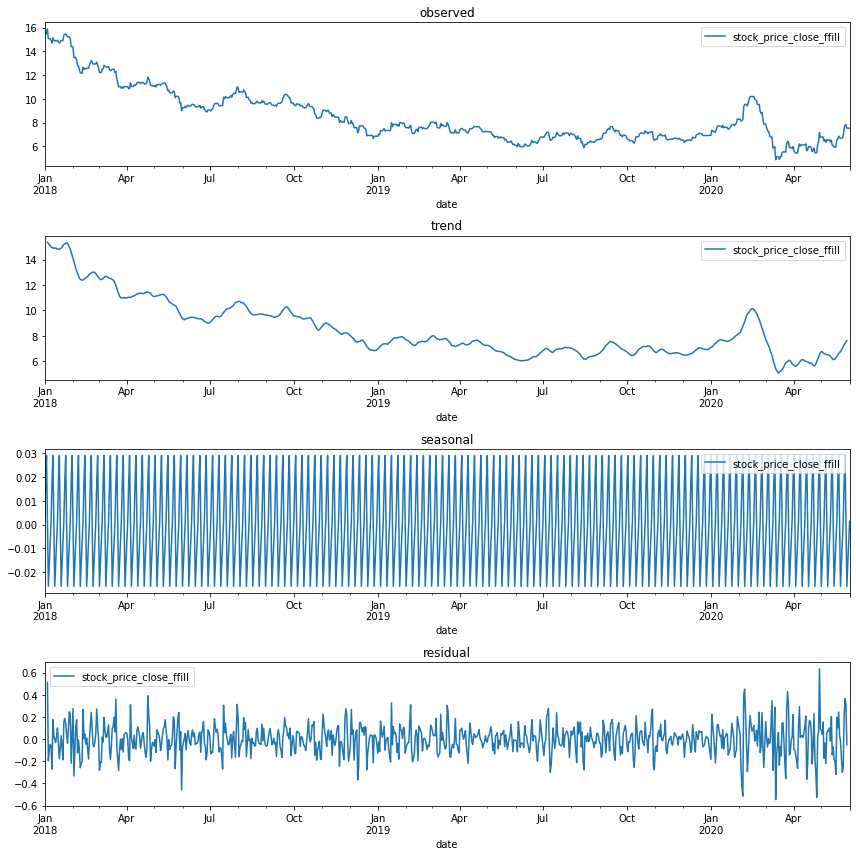

In [ ]:
plot_decomposition(deutsche_bank)

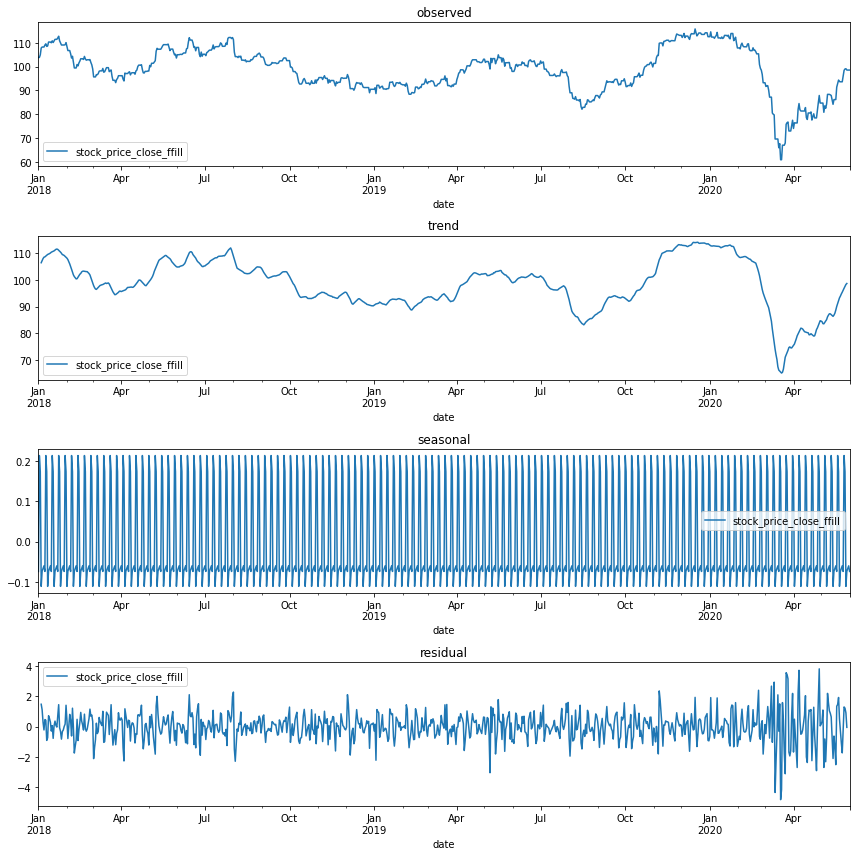

In [ ]:
plot_decomposition(siemens)

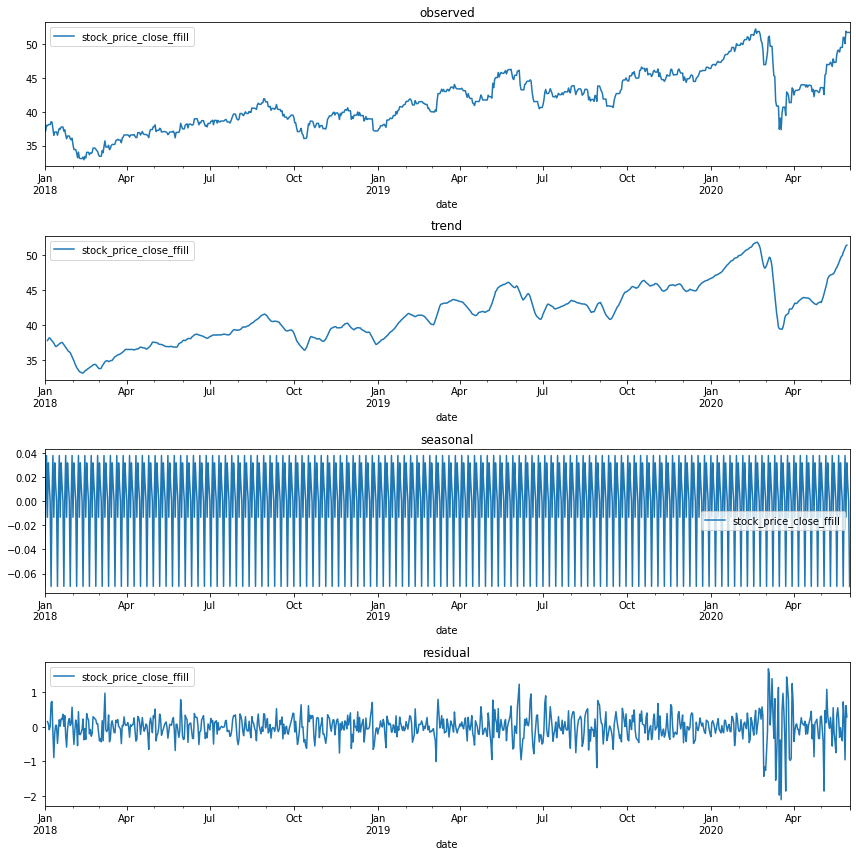

In [ ]:
plot_decomposition(vonovia)

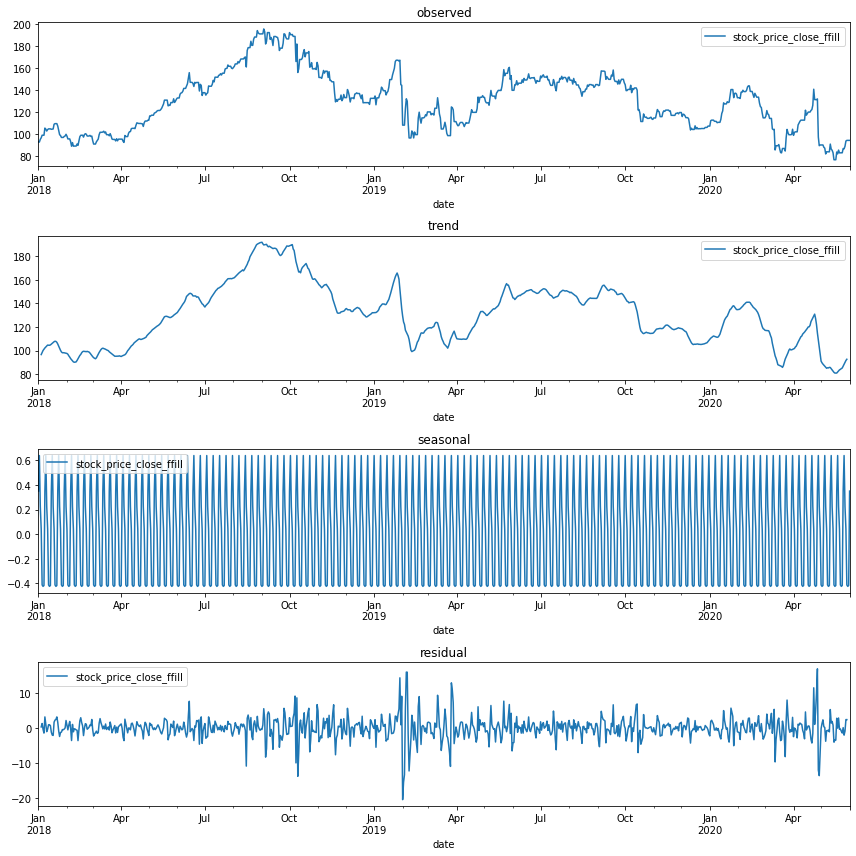

In [ ]:
plot_decomposition(wirecard)